<a href="https://colab.research.google.com/github/NUST-Xiaocao/TRANSMC/blob/main/transmusic128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# import package

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from scipy.linalg import orth

import random
from scipy import linalg
from scipy import signal
import time
import scipy
import math
import h5py
from tqdm.auto import tqdm
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

import os

myseed = 42069
torch.backends.cudnn.deterministic = True

torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
torch.cuda.manual_seed_all(myseed)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'


print('The device used is', device)

The device used is cuda


# construct training data

In [2]:
d = 5   # Number of targets
m = 8   # Number of antenna arrays
snr = 10   # Signal to Noise Ratio

mean_signal_power = 0  #Signal mean
var_signal_power = 1  #Signal variance

mean_noise = 0  #Mean noise
var_noise = 1  #noise variance


doa = np.pi * (np.random.rand(d) - 1/2)
p = np.sqrt(1) * (np.random.randn(d) + np.random.randn(d) * 1j)

array = np.linspace(0, m, m, endpoint=False)
angles = np.array((np.linspace(- np.pi/2, np.pi/2, 360, endpoint=False),))
r = angles.shape[1]
snapshots = 200



#*******************************************#
#   uniform linear array steering vector    #
#*******************************************#
def ULA_action_vector(theta):

    array = np.linspace(0, m, m, endpoint=False)
    return np.exp(- 1j * np.pi * array * np.sin(theta))



#***********************#
#   construct signals   #
#***********************#
def construct_signal(thetas,snr,snapshots):


    d = len(thetas)

    signal = np.sqrt(var_signal_power) * (10 ** (snr / 10)) *  (np.random.randn(d, snapshots) + 1j * np.random.randn(d, snapshots)) + mean_signal_power

    A = np.array([ULA_action_vector(thetas[j]) for j in range(d)])

    noise = np.sqrt(var_noise) * (np.random.randn(m, snapshots) + 1j *np.random.randn(m, snapshots)) + mean_noise

    return np.dot(A.T, signal) + noise, signal



#********************************#
#   construct coherent signals   #
#********************************#
def construct_coherent_signal(thetas,snr,snapshots):

    d = len(thetas)

    signal = np.sqrt(var_signal_power) * (10 ** (snr / 10)) * (np.random.randn(1, snapshots) + 1j * np.random.randn(1, snapshots)) + mean_signal_power

    signal = np.repeat(signal, d, axis=0)

    A = np.array([ULA_action_vector(thetas[j]) for j in range(d)])
    noise = np.sqrt(var_noise) * (np.random.randn(m, snapshots) + 1j *np.random.randn(m, snapshots)) + mean_noise

    return np.dot(A.T, signal) + noise, signal




# ********************#
#   create dataset   #
# ********************#
def create_dataset(name, size,snr,snapshots ,coherent=False, save=True):

    X = np.zeros((size, m, snapshots)) + 1j * np.zeros((size, m, snapshots))
    Thetas = np.zeros((size, d))

    for i in tqdm(range(size)):
        thetas = np.pi * (np.random.rand(d) - 1 / 2)
        if coherent:
            X[i] = construct_coherent_signal(thetas,snr,snapshots)[0]
        else:
            X[i] = construct_signal(thetas,snr,snapshots)[0]
        Thetas[i] = thetas

    if save:
        hf = h5py.File(name + '.h5', 'w')
        hf.create_dataset('X', data=X)
        hf.create_dataset('Y', data=Thetas)
        hf.close()

    return X, Thetas




# ********************#
#   create dataset   #
# ********************#
def create_dataset(name, size,snr,snapshots ,coherent=False, save=True):

    X = np.zeros((size, m, snapshots)) + 1j * np.zeros((size, m, snapshots))
    Thetas = np.zeros((size, d))

    for i in tqdm(range(size)):
        thetas = np.pi * (np.random.rand(d) - 1 / 2)  # random source directions
        if coherent:
            X[i] = construct_coherent_signal(thetas,snr,snapshots)[0]
        else:
            X[i] = construct_signal(thetas,snr,snapshots)[0]
        Thetas[i] = thetas

    if save:
        hf = h5py.File(name + '.h5', 'w')
        hf.create_dataset('X', data=X)
        hf.create_dataset('Y', data=Thetas)
        hf.close()

    # return X, Thetas



#***************************************#
#   create dataset with large variety   #
#***************************************#
def create_complete_dataset(name, size,snr, snapshots,num_sources=[d], coherent=False, save=True):

    X = np.zeros((size, m, snapshots)) + 1j * np.zeros((size, m, snapshots))
    Thetas = np.zeros((size, 6))
    for i in tqdm(range(size)):
        num = num_sources[i % len(num_sources)]   # create equal sized sets for each num. of sources
        thetas = np.pi * (np.random.rand(num) - 1/2)   # random source direction

        if coherent:
            X[i] = construct_coherent_signal(thetas,snr,snapshots)[0]
        else:
            X[i] = construct_signal(thetas,snr,snapshots)[0]
        Thetas[i] = np.pad(thetas, (0, 6 - num), 'constant', constant_values=np.pi)

    if save:
        hf = h5py.File(name + '.h5', 'w')
        hf.create_dataset('X', data=X)
        hf.create_dataset('Y', data=Thetas)
        hf.close()

    # return X, Thetas


#***************************************#
#   create dataset with large variety   #
#***************************************#
def create_complete_mixsnr_dataset(name,size,snapshots,num_sources=[d], coherent=False, save=True):

    X = np.zeros((size, m, snapshots)) + 1j * np.zeros((size, m, snapshots))
    Thetas = np.zeros((size, 6))

    snr_list=[ 0, 5,10]

    for i in tqdm(range(size)):
        num = num_sources[i % len(num_sources)]   # create equal sized sets for each num. of sources
        thetas = np.pi * (np.random.rand(num) - 1/2)   # random source direction

        snr=snr_list[i % len(snr_list)]

        if coherent:
            X[i] = construct_coherent_signal(thetas,snr,snapshots)[0]
        else:
            X[i] = construct_signal(thetas,snr,snapshots)[0]
        Thetas[i] = np.pad(thetas, (0, 6 - num), 'constant', constant_values=np.pi)


    if save:
        hf = h5py.File(name + '.h5', 'w')
        hf.create_dataset('X', data=X)
        hf.create_dataset('Y', data=Thetas)
        hf.close()






# ********************#
#   create dataset   #
# ********************#
def create_test_data(size,snr,snapshots ,coherent=False):

    X = np.zeros((size, m, snapshots)) + 1j * np.zeros((size, m, snapshots))
    Thetas = np.zeros((size, d))
    for i in tqdm(range(size)):
        thetas = np.pi * (np.random.rand(d) - 1 / 2)  # random source directions
        if coherent:
            X[i] = construct_coherent_signal(thetas,snr,snapshots)[0]
        else:
            X[i] = construct_signal(thetas,snr,snapshots)[0]
        Thetas[i] = thetas

    return X, Thetas



def create_complete_test_dataset(size,snr, snapshots,num_sources=[d], coherent=False):

    X = np.zeros((size, m, snapshots)) + 1j * np.zeros((size, m, snapshots))
    Thetas = np.zeros((size, 6))
    for i in (range(size)):
        num = num_sources[i % len(num_sources)]   # create equal sized sets for each num. of sources
        thetas = np.pi * (np.random.rand(num) - 1/2)   # random source direction

        if coherent:
            X[i] = construct_coherent_signal(thetas,snr,snapshots)[0]
        else:
            X[i] = construct_signal(thetas,snr,snapshots)[0]
        Thetas[i] = np.pad(thetas, (0, 6 - num), 'constant', constant_values=np.pi)


    return X, Thetas





def permutations(predDoA):

    if len(predDoA) == 0:
        return []
    if len(predDoA) == 1:
        return [predDoA]

    perms = []

    for i in range(len(predDoA)):
       remaining = predDoA[:i] + predDoA[i + 1:]

       for perm in permutations(remaining):

           perms.append([predDoA[i]] + perm)

    return perms





#*******************************#
#   cluster small eigenvalues   #
#*******************************#
def cluster(evs):


    threshold = 1.25   # non-coherent
    # threshold = 0.1   # coherent
    return evs[ np.where(abs(evs) <    abs(evs[-1]) + threshold   )        ]

#*********************************#
#   the classic MUSIC algorithm   #
#*********************************#
def classicMUSIC(incident, array, continuum, sources=None):

    covariance = np.cov(incident)
    eigenvalues, eigenvectors = linalg.eig(covariance)

    if sources:   # number of sources known
        d = sources
    else:
        n = cluster(eigenvalues).shape[0]
        d = array.shape[0] - n   # and get number of signal sources

    En = eigenvectors[:, d:]

    numSamples = continuum.shape[1]
    spectrum = np.zeros(numSamples)
    for axis in continuum:
        for i in range(numSamples):
            a = ULA_action_vector(array, axis[i])
            spectrum[i] = 1./(a.conj().transpose() @ En @ En.conj().transpose() @ a)

    DoA, _ = signal.find_peaks(spectrum)

    DoA = DoA[np.argsort(spectrum[DoA])[-d:]]

    return DoA, spectrum,d



#*********************************#
#   the classic MUSIC algorithm   #
#*********************************#
def One_bit_MUSIC(incident, array, continuum, sources=None):

    covariance = np.cov(incident)##covariance matrix

    coveriance=np.pi/2*covariance;

    coveriance=np.sin(coveriance)+1j*np.sin(covariance)

    eigenvalues, eigenvectors = linalg.eig(covariance)


    if sources:   # number of sources known
        d = sources
    else:
        n = cluster(eigenvalues).shape[0]   # estimate multiplicity of smallest eigenvalue...
        d = array.shape[0] - n   # and get number of signal sources

    En = eigenvectors[:, d:]

    numSamples = continuum.shape[1]
    spectrum = np.zeros(numSamples)
    for axis in continuum:
        for i in range(numSamples):
            a = ULA_action_vector(array, axis[i])
            spectrum[i] = 1./(a.conj().transpose() @ En @ En.conj().transpose() @ a)

    DoA, _ = signal.find_peaks(spectrum)

    DoA = DoA[np.argsort(spectrum[DoA])[-d:]]

    return DoA, spectrum,d


#******************************#
#   the Beamformer algorithm   #
#******************************#
def beamformer(incident, array, continuum, sources=None):

    covariance = np.cov(incident)

    numSamples = continuum.shape[1]
    spectrum = np.zeros(numSamples)


    for axis in continuum:
        for i in range(numSamples):

            a = ULA_action_vector(array, axis[i])
            spectrum[i] = abs(a.conj().transpose() @ covariance @ a) / linalg.norm(a)**2

    DoAsMUSIC, _ = signal.find_peaks(spectrum)



    if sources: DoAsMUSIC = DoAsMUSIC[np.argsort(spectrum[DoAsMUSIC])[-sources:]]


    else: DoAsMUSIC = DoAsMUSIC[np.argsort(- spectrum[DoAsMUSIC])]

    return DoAsMUSIC, spectrum

#***********************************#
#   mean minimal permutation rmse   #
#***********************************#
def mean_min_perm_rmse(predDoA, trueDoA):

    num_samples = trueDoA.shape[0]

    allMSE = np.zeros(num_samples)
    for i in range(num_samples):


        diffs = np.zeros(np.math.factorial(trueDoA.shape[1]))
        for j, perm in enumerate(permutations(list(predDoA[i]))):


            diff = ((perm - trueDoA[i]) + np.pi / 2) % np.pi - np.pi / 2


            diffs[j] = np.mean(diff ** 2) ** (1 / 2)


        allMSE[i] = np.amin(diffs)

    return np.mean(allMSE)








# generate training data

In [3]:
num_train=200000
num_val=20000
num_val_snr=5000


create_complete_dataset('train_nocoherent_snr10_200k', num_train, snr,snapshots,num_sources=[2,3,4,5], coherent=False)
create_complete_dataset('validation_nocoherent_snr10_20k', num_val, snr,snapshots,num_sources=[2,3,4,5], coherent=False)
#依次对应 数据集名字 数据集大小，信噪比，快照数，信源的数量列表，是否生成相干信号，
create_complete_dataset('vali(100)_nocoherent_snr10_5k', num_val_snr, 10,100,num_sources=[2,3,4,5], coherent=False)
create_complete_dataset('vali(0)2d_nocoherent_snr10_5k', num_val_snr, 10,snapshots,num_sources=[2], coherent=False)



# create_complete_mixsnr_dataset('data/train_nocoherent_snrmix_200k', num_train,200,num_sources=[2,3,4,5], coherent=False)
# create_complete_mixsnr_dataset('data/validation_nocoherent_snrmix_20k', num_val,200,num_sources=[2,3,4,5], coherent=False)
# create_complete_dataset('data/vali(0)_nocoherent_snr0_10k', num_val_snr, 0,200,num_sources=[2,3,4,5], coherent=False)
# create_complete_dataset('data/vali(-5)_nocoherent_snr-5_10k', num_val_snr, -5,200,num_sources=[2,3,4,5], coherent=False)



  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

#  dataset

In [4]:
class Deep_augmented_MUSIC_Dataset(Dataset):
    def __init__(self, x, y=None):   #X is the input data, y is the target data

        self.data = torch.from_numpy(x).float()
        # self.data = torch.FloatTensor(x)


        if y is not None:

            self.label = torch.from_numpy(y).float()
        else:
            self.label = None



    def __getitem__(self, index):
        if self.label is not None:
            return self.data[index], self.label[index]
        else:
            return self.data[index]

    def __len__(self):
        return len(self.data)


In [5]:




hf_train = h5py.File('train_nocoherent_snr10_200k.h5', 'r')#read data
hf_val = h5py.File('validation_nocoherent_snr10_20k.h5', 'r')#
hf_val_snr = h5py.File('vali(100)_nocoherent_snr10_5k.h5', 'r')#
hf_val_s = h5py.File('vali(0)2d_nocoherent_snr10_5k.h5', 'r')#

# hf_train = h5py.File('data/train_coherent_d5_snr10_256k.h5', 'r')##read data
# hf_val = h5py.File('data/validation_coherent_d5_snr10_25.6k.h5', 'r')#

X_train = np.array(hf_train.get('X'))

Y_train = np.array(hf_train.get('Y'))

X_val = np.array(hf_val.get('X'))
Y_val = np.array(hf_val.get('Y'))


X_val_snr = np.array(hf_val_snr.get('X'))
Y_val_snr = np.array(hf_val_snr.get('Y'))

X_val_s = np.array(hf_val_s.get('X'))
Y_val_s = np.array(hf_val_s.get('Y'))



X_train=np.concatenate([X_train.real, X_train.imag], axis=1)#Splicing complex numbers into real numbers
X_val=np.concatenate([X_val.real, X_val.imag], axis=1)#Splicing complex numbers into real numbers
X_val_snr=np.concatenate([X_val_snr.real, X_val_snr.imag], axis=1)#Splicing complex numbers into real numbers
X_val_s=np.concatenate([X_val_s.real, X_val_s.imag], axis=1)#Splicing complex numbers into real numbers



# X_train=np.sign(X_train)#onebit bit quantization
# X_val=np.sign(X_val)#onebit bit quantization


X_train=np.sign(X_train)#onebit bit quantization
X_val=np.sign(X_val)#onebit bit quantization
X_val_snr=np.sign(X_val_snr)#onebit bit quantization
X_val_s=np.sign(X_val_s)#onebit bit quantization



print("Training Set Size:","Y_train",Y_train.shape,"X_train",X_train.shape,X_train.dtype)
print("Verification set size:","Y_val",Y_val.shape,"X_val",X_val.shape,X_val.dtype)
print("Verification set snapshot size:","Y_val_snr",Y_val_snr.shape,"X_val",X_val_snr.shape,X_val_snr.dtype)
print("Verify snapshot set size:","Y_val_s",Y_val_s.shape,"X_val",X_val_s.shape,X_val_s.dtype)


train_set = Deep_augmented_MUSIC_Dataset(X_train,Y_train)
val_set = Deep_augmented_MUSIC_Dataset(X_val,Y_val)

val_set_snr = Deep_augmented_MUSIC_Dataset(X_val_snr,Y_val_snr)
val_set_s = Deep_augmented_MUSIC_Dataset(X_val_s,Y_val_s)


batch_size=128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,drop_last=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,drop_last=True)

valid_loader_snr = DataLoader(val_set_snr, batch_size=batch_size, shuffle=False,drop_last=True)
valid_loader_s = DataLoader(val_set_s, batch_size=batch_size, shuffle=False,drop_last=True)




Training Set Size: Y_train (200000, 6) X_train (200000, 16, 200) float64
Verification set size: Y_val (20000, 6) X_val (20000, 16, 200) float64
Verification set snapshot size: Y_val_snr (5000, 6) X_val (5000, 16, 100) float64
Verify snapshot set size: Y_val_s (5000, 6) X_val (5000, 16, 200) float64


#  doa estimation network

In [6]:
a=torch.zeros([m,r])+1j*torch.zeros([m,r])
for i in range(r):
    a[:,i] =torch.from_numpy(ULA_action_vector(angles[0,i]))
a=torch.complex(a.real.float(),a.imag.float()).to(device)


def calculate_spectrum(En):

    H1=torch.matmul(En.to(device)@ torch.conj(En.permute(0,2,1)).to(device),a).to(device)

    H2=torch.mul(H1,torch.conj(a))

    H3=torch.sum(H2,dim=1)

    return (1.0/abs(H3)).to(device)



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):

        x = x.to(device)  + self.pe[:x.size(0)].to(device)

        return x



# #**********************************#
#   trans_music                    #
#**********************************#

class calculate_EVD(nn.Module):
    def __init__(self):
        super(calculate_EVD, self).__init__()


    def forward(self, x):

        size=x.shape[0]#Get batch_ Size size

        #Become pseudo Covariance matrix
        x=torch.complex(x[ :,:8 ,:].to(device),x[ :,8: ,:].to(device))    #  [size,8,8]
        #Eigenvector decomposition
        xVal, xVec=torch.linalg.eig(x)
        xVal_=abs(xVal).to(device)    #From small to large row
        xVal_,idx=torch.sort(xVal_, dim=1) #Sort feature values to obtain an index
        x4=xVec.to(device)
        order_vec=torch.zeros([size,m,m]).to(device)+1j*torch.zeros([size,m,m]).to(device)
        order_value=torch.zeros([size,m]).to(device)+1j*torch.zeros([size,m]).to(device)
        order_vec=order_vec.to(device)
        order_value=order_value.to(device)


        for i in range(size):

            order_vec[i,:,:]=x4[i].index_select(1,idx[i]).unsqueeze(dim=0)
            order_value[i,:]=xVal[i].index_select(0,idx[i]).unsqueeze(dim=0)

        return order_value,order_vec




class RNN_music_EVD_two(nn.Module):

    def __init__(self,m):

        super(RNN_music_EVD_two, self).__init__()

        self.m=m

        self.BN=torch.nn.BatchNorm1d(2*self.m).to(device)
        # self.LN= torch.nn.LayerNorm(normalized_shape = [16]).to(device)

        self.evd=calculate_EVD().to(device)

        self.gru_layer = nn.GRU(2*self.m, 2*self.m,batch_first=True).to(device)

        self.input_linear = nn.Linear(in_features=16, out_features=128).to(device)


        self.change_noise = nn.Sequential(
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=16, out_features=8),
            nn.Sigmoid()
                ).to(device)



        self.output = nn.Sequential(
            nn.Linear(in_features=360, out_features=16) ,
            nn.ReLU(inplace=False),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=16, out_features=16) ,
            nn.ReLU(inplace=False),
            nn.Linear(in_features=16, out_features=6)
                ).to(device)


        self.output_d = nn.Sequential(
            nn.Linear(in_features=16, out_features=128),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=128, out_features=128) ,
            nn.ReLU(inplace=False),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=128, out_features=128),
            nn.Linear(in_features=128, out_features=4),
                ).to(device)


    def forward(self,x,sub=True):




        size=x.shape[0]

        # x=x.permute(0,2,1).float().to(device)#
        # x=self.LN(x).to(device)

        # x=x.permute(0,2,1).float().to(device)#
        x=self.BN(x).to(device)


        x=x.permute(0,2,1).float().to(device)# Swap the first and second dimensions into [size, 200,16]

        _,x=self.gru_layer(x) #By gating the loop unit (GRU) to [size, 16]

        x=self.input_linear(x).to(device) #The GRU output is passed to a fully connected layer, and the output 2 * 8 * 8=128 dimensions becomes [size, 128]

        x=x.reshape(size,16,8).to(device) #Map it to two-dimensional pseudo covariance ˜ K 16 * 8 becomes [size, 16,8]]


        #Eigenvector decomposition
        xVal,xVec=self.evd(x)

        xVal=xVal.detach()#Truncated gradient flow
        xVal=torch.cat([xVal.real.float().to(device), xVal.imag.float().to(device)],dim=1)  # [size,16]


        #Noise subspace selector
        p=self.change_noise(xVal.to(device)) #[size,8]
        p1=p
        p=torch.diag_embed(p)  #Weight value   [size,8,8]
        p=torch.complex(p,torch.zeros([size,8,8]).float().to(device)).to(device)  #[size,8,8]
        x1=torch.matmul(p.to(device),xVec.to(device)) #Weighting eigenvectors [size,8,8]*[size,8,8]


        #Calculate spectrum
        x1=calculate_spectrum(x1).to(device)

        #Peak Finder
        x1=self.output(x1.to(device)).to(device)

        #Classifier for estimating d
        x2=self.output_d(xVal)

        return x1,x2,xVal



#**********************************#
#   trans_music                    #
#**********************************#

class trans_music_two(nn.Module):

    def __init__(self,m):

        super(trans_music_two, self).__init__()

        self.m=m

        self.BN=torch.nn.BatchNorm1d(16).to(device)
        # self.LN= torch.nn.LayerNorm(normalized_shape = [16]).to(device)

        self.pos_encoder = PositionalEncoding(16)#Position embedding

        encoder_layer=torch.nn.TransformerEncoderLayer(    #Define encoder layer
            d_model=16,
            nhead=8, ##The number of heads in a multi head attention model
            dim_feedforward=1024, #Dimensions of feedforward network models
            dropout=0, #Dropout value
            activation="relu",
            layer_norm_eps=1e-05,
            batch_first=True,
            norm_first=False,
            device=None,
            dtype=None).to(device)


        self.encoder=torch.nn.TransformerEncoder(
            encoder_layer,
            num_layers=3,
            norm=None).to(device)

        self.input_linear = nn.Linear(in_features=16, out_features=128).to(device)

        self.output = nn.Sequential(

            nn.Linear(in_features=360, out_features=16) ,
            nn.ReLU(inplace=False),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=16, out_features=16) ,
            nn.ReLU(inplace=False),
            nn.Linear(in_features=16, out_features=6)
                ).to(device)



        self.output_d = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=128, out_features=128) ,
            nn.ReLU(inplace=False),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=32, out_features=4)
                ).to(device)


    def forward(self, x):



        #The input X is [size, 16200] batch_ Size=16, input dimension 16, sequence length 200


        size=x.shape[0]#Get batch_ Size size

        # x=x.permute(0,2,1).float().to(device)# Exchange dimension becomes [size, 200,16]

        x=self.BN(x).to(device)#Become [size, 16200]

        # x=self.LN(x.to(device)).to(device)


        x=x.permute(2,0,1).float().to(device)# Exchange dimension becomes [200, size, 16]

        #Position embedding
        x=self.pos_encoder(x.to(device)).to(device)  #x: Tensor, shape [seq_len, batch_size, embedding_dim]

        x=x.permute(1,0,2).float().to(device)# Exchange dimension becomes [size, 200,16]

        x1=self.encoder(x.to(device) )    #Transformer_ Encoder network output becomes [size, 200,16]

        x2=torch.mean(x1,dim=1) #Output becomes [size, 16]

        x3=self.input_linear(x2).to(device) #The output is passed to a fully connected layer and becomes [size, 128]

        vector=x3 #

        x4=x3.reshape(size,16,8).to(device) #Change its mapping covariance to [size, 16,8]

        # vector=x4  #CNN for classifier

        x5=torch.complex(x4[ :,:8 ,:].to(device),x4[ :,8: ,:].to(device))    #feature vector  [size,8,8]


        x6=calculate_spectrum(x5).to(device)  #Calculate spectrum

        x7=x6.float().to(device)

        x8=self.output(x7.to(device)).to(device)


        #Classifier for estimating D
        x9=x3  #[size,16]
        x9=x9.detach()#Truncated gradient flow
        x9=self.output_d(x9)


        return x8,x9,vector





class trans_music_two_LN(nn.Module):

    def __init__(self,m):

        super(trans_music_two_LN, self).__init__()

        self.m=m

        # self.BN=torch.nn.BatchNorm1d(16).to(device)
        self.LN= torch.nn.LayerNorm(normalized_shape = [16]).to(device)

        self.pos_encoder = PositionalEncoding(16)#Positional embedding

        encoder_layer=torch.nn.TransformerEncoderLayer(    #Define encoder layer
            d_model=16,
            nhead=8, ##The number of heads in the multi head attention model
            dim_feedforward=1024, #Dimension of feedforward network model
            dropout=0, #Dropout value
            activation="relu",
            layer_norm_eps=1e-05,
            batch_first=True,
            norm_first=False,
            device=None,
            dtype=None).to(device)


        self.encoder=torch.nn.TransformerEncoder(
            encoder_layer,
            num_layers=3,
            norm=None).to(device)

        self.input_linear = nn.Linear(in_features=16, out_features=128).to(device)

        self.output = nn.Sequential(

            nn.Linear(in_features=360, out_features=16) ,
            nn.ReLU(inplace=False),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=16, out_features=16) ,
            nn.ReLU(inplace=False),
            nn.Linear(in_features=16, out_features=6)
                ).to(device)



        self.output_d = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=128, out_features=128) ,
            nn.ReLU(inplace=False),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=32, out_features=4)
                ).to(device)


    def forward(self, x):

        #Suppose batch_ Size=16


        #The entered x is [size, 16200] batch_ Size=16, enter dimension 16, sequence length 200


        size=x.shape[0]#Get batch_ Size size

        x=x.permute(0,2,1).float().to(device)# Exchange dimension becomes [size, 200,16]
        # x=self.BN(x).to(device)#[size,16,200]

        x=self.LN(x.to(device)).to(device)


        x=x.permute(1,0,2).float().to(device)# [200,size,16]

        #Positional embedding
        x=self.pos_encoder(x.to(device)).to(device)  #x: Tensor, shape [seq_len, batch_size, embedding_dim]

        x=x.permute(1,0,2).float().to(device)# [size,200,16]

        x1=self.encoder(x.to(device) )    #Transformer_ The encoder network output becomes [size, 200,16]

        x2=torch.mean(x1,dim=1) #[size,16]

        x3=self.input_linear(x2).to(device) #The output is passed to a full connection layer and becomes [size, 128]

        vector=x3 #

        x4=x3.reshape(size,16,8).to(device) #Change its mapping covariance to [size, 16,8]

        # vector=x4  #

        x5=torch.complex(x4[ :,:8 ,:].to(device),x4[ :,8: ,:].to(device))    #Eigenvector [size, 8,8]


        x6=calculate_spectrum(x5).to(device)             #Calculate spectrum

        x7=x6.float().to(device)

        x8=self.output(x7.to(device)).to(device)


        #Classifier for estimating D
        x9=x3  #[size,16]
        x9=x9.detach()#Truncated gradient flow
        x9=self.output_d(x9)


        return x8,x9,vector



#  classifier network

In [10]:


class separate_est_d(nn.Module):
    def __init__(self,name):
        super(separate_est_d, self).__init__()

        # self.BN=torch.nn.BatchNorm1d(128).to(device)

        self.output_d = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=128, out_features=128) ,
            nn.ReLU(inplace=False),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=32, out_features=4)
                ).to(device)
        self.net_DOA=trans_music_two(m=8).to(device)
        self.net_DOA.load_state_dict(torch.load(name))#Model parameter loading
    def forward(self, x):
        with torch.no_grad():  # disable gradient calculation
            x8,x9,x3 = self.net_DOA(x)  #  value  [size,16]

        x10=x3  #[size,16]
        x10=x10.detach()#Truncated gradient flow
        # x10=self.BN(x10).to(device)
        x10=self.output_d(x10)
        return x10


class separate_est_d2(nn.Module):
    def __init__(self,name):
        super(separate_est_d2, self).__init__()

        # self.BN=torch.nn.BatchNorm1d(128).to(device)

        self.output_d = nn.Sequential(
            nn.Linear(in_features=16, out_features=128),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=128, out_features=128) ,
            nn.ReLU(inplace=False),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=128, out_features=128),
            nn.Linear(in_features=128, out_features=4)
                ).to(device)
        self.net_DOA=RNN_music_EVD_two(m=8).to(device)
        self.net_DOA.load_state_dict(torch.load(name))
    def forward(self, x):
        with torch.no_grad():  # disable gradient calculation
            x8,x9,x3 = self.net_DOA(x)  #  value  [size,16]

        x10=x3  #[size,16]
        x10=x10.detach()
        # x10=self.BN(x10).to(device)
        x10=self.output_d(x10)
        return x10




#  loss function

In [7]:
#****************************#
#     #Calculate permutation
#****************************#
def permutations(predDoA):

    if len(predDoA) == 0:
        return []
    if len(predDoA) == 1:
        return [predDoA]

    perms = []

    for i in range(len(predDoA)):
       remaining = predDoA[:i] + predDoA[i + 1:]

       for perm in permutations(remaining):

           perms.append([predDoA[i]] + perm)

    return perms


a2=[[1,0],[0,1]]
a2=permutations(a2)
b2=np.array(a2)
perm2=b2.reshape(np.math.factorial(2)*2,2)
perm2=perm2.swapaxes(0,1)
print(perm2.shape)
perm2=torch.from_numpy(perm2).float().to(device)



a3=[[1,0,0],[0,1,0,],[0,0,1]]
a3=permutations(a3);
b3=np.array(a3)
perm3=b3.reshape(np.math.factorial(3)*3,3)
perm3=perm3.swapaxes(0,1)
print(perm3.shape)
perm3=torch.from_numpy(perm3).float().to(device)


a4=[[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
a4=permutations(a4)
b4=np.array(a4)
perm4=b4.reshape(np.math.factorial(4)*4,4)
perm4=perm4.swapaxes(0,1)
print(perm4.shape)
perm4=torch.from_numpy(perm4).float().to(device)



a5=[[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]
a5=permutations(a5)
b5=np.array(a5)
perm5=b5.reshape(np.math.factorial(5)*5,5)
perm5=perm5.swapaxes(0,1)
print(perm5.shape)
perm5=torch.from_numpy(perm5).float().to(device)



def perm_rmse(predDoA, trueDoA):

    size=trueDoA.shape[0]
    num_sources = trueDoA.shape[1]

    allPerms=torch.zeros(size,np.math.factorial(num_sources)*num_sources,requires_grad=True);

    if num_sources==2:
        allPerms=torch.matmul(trueDoA.to(device) ,perm2.to(device) ).to(device)  #  [size,2]  [2,4]   =[size,4]
        allPerms=allPerms.reshape(size,2,2).to(device)      # size  2   2

    elif num_sources==3:
        allPerms=torch.matmul(trueDoA.to(device) ,perm3.to(device) ).to(device)  #  [size,3]  [3,18]   =[size,18]
        allPerms=allPerms.reshape(size,6,3).to(device)      # size  6   3

    elif num_sources==4:
        allPerms=torch.matmul(trueDoA.to(device) ,perm4.to(device) ).to(device)  #  [size,4]  [4,96]   =[size,96]
        allPerms=allPerms.reshape(size,24,4).to(device)      # size  24   4

    elif num_sources==5:
        allPerms=torch.matmul(trueDoA.to(device) ,perm5.to(device) ).to(device)  #  [size,5]  [5,600]   =[size,600]
        allPerms=allPerms.reshape(size,120,5).to(device)      # size  120   5

    predDoA=predDoA.unsqueeze(1).to(device)

    diff=torch.fmod( allPerms-predDoA+np.pi / 2 , np.pi ) - np.pi / 2

    diff2,ind=torch.min(torch.mean(diff**2,dim=2)**(1/2),dim=1)

    return  torch.mean(diff2)


# def perm_rmse(predDoA, trueDoA):


#     size=trueDoA.shape[0]#
#     num_sources = trueDoA.shape[1]

#     allPerms = np.zeros((size, np.math.factorial(num_sources), num_sources))# 1 120   5

#     for i in range(size):

#         allPerms[i] = permutations(list(trueDoA[i].cpu().numpy()))

#     allPerms=torch.from_numpy(allPerms).to(device)

#     predDoA=predDoA.unsqueeze(1)

#     diff=torch.fmod( allPerms-predDoA+np.pi / 2 , np.pi ) - np.pi / 2

#     diff2,ind=torch.min(torch.mean(diff**2,dim=2)**(1/2),dim=1)

#     return  torch.mean(diff2)


#***************#
#   mean rmse   #
#***************#
def loss_doa(predDoA,trueDoA):

    num_true = torch.argmax(trueDoA, dim=1)

    diff = torch.zeros(1).to(device)

    for i, elem in enumerate(num_true):

        diff=diff+perm_rmse(predDoA[i, :elem].unsqueeze(dim=0),trueDoA[i, :elem].unsqueeze(dim=0))

    diff= diff/len(num_true)

    return diff



def  loss_d(predp,trueDoA):

    num_true = torch.argmax(trueDoA, dim=1)

    criterion = nn.CrossEntropyLoss()

    dd = torch.zeros(trueDoA.shape[0],4).to(device)#{size,4}

    for i in range(trueDoA.shape[0]):
       dd[i][num_true[i]-2]=1;

    return  criterion(predp,dd)





def  loss_d_by_one(predp,trueDoA):

    size=trueDoA.shape[0]

    num_true = torch.argmax(trueDoA, dim=1)

    num_true=num_true.reshape(size,1)

    diff=abs(predp-num_true)

    return  torch.mean(diff)



def loss_doa_test(predDoA,trueDoA,num_true_t,num_true_p):

    diff = torch.zeros(1).to(device)

    for i, elem in enumerate(num_true_t):

        if num_true_p[i]==num_true_t[i]:

            diff=diff+perm_rmse(predDoA[i, :elem].unsqueeze(dim=0),trueDoA[i, :elem].unsqueeze(dim=0))

        elif num_true_p[i]>num_true_t[i]:

            diff=diff+perm_rmse(predDoA[i, :elem].unsqueeze(dim=0),trueDoA[i, :elem].unsqueeze(dim=0))

        elif num_true_p[i]<num_true_t[i]:

            predDoA[i,num_true_p[i]:]=(torch.rand(1,6-num_true_p[i])-0.5)*torch.pi

            diff=diff+perm_rmse(predDoA[i, :elem].unsqueeze(dim=0),trueDoA[i, :elem].unsqueeze(dim=0))

    diff= diff/len(num_true_t)

    return diff

(2, 4)
(3, 18)
(4, 96)
(5, 600)


<ipython-input-7-dce6489c3731>:26: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  perm2=b2.reshape(np.math.factorial(2)*2,2)
<ipython-input-7-dce6489c3731>:36: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  perm3=b3.reshape(np.math.factorial(3)*3,3)
<ipython-input-7-dce6489c3731>:45: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  perm4=b4.reshape(np.math.factorial(4)*4,4)
<ipython-input-7-dce6489c3731>:55: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  perm5=b5.reshape(np.math.factorial(5)*5,5)


# define Network

In [8]:

T1=1
T2=0
T5=0
T6=0

T7=0
A3=0
A1=0
T3=0


train_loss_record=[]
valid_loss_record=[]

best_loss=1
break_flag=0
train_time =[]
best_acc=0

net=0
if not os.path.exists('./model_d/'):
    os.makedirs('./model_d/')
model_location='./model_d/'



# if DOAnet==1:
#     net=trans_music(m=8).to(device)
#     model_location='./model_d/trans_music.pt'


if T1==1:
    net=trans_music_two(m=8)
    model_location='./model_d/transmusic128.pt'


if T2==1:
    net=separate_est_d('./model_d/transmusic.pt')
    model_location='./model_d/transmusic_分类器.pt'


if T5==1:
    net=trans_music_two(m=8)
    model_location='./model_d/transmusic_onebit.pt'


if T6==1:
    net=separate_est_d('./model_d/transmusic_onebit.pt')
    model_location='./model_d/transmusic_onebit_分类器.pt'



if T3==1:
    net=trans_music_two(m=8)
    model_location='./model_d/transmusic_onebit.pt'



if T7==1:
    net=trans_music_two(m=8)
    model_location='./model_d/transmusic_onebit_相干.pt'


if A3==1:
    net=separate_est_d2('./model_d/DA_music.pt')
    model_location='./model_d/DA_music_分类器.pt'

if A1==1:
    net=RNN_music_EVD_two(m=8)
    model_location='./model_d/DA_music.pt'



#for name, param in net.named_parameters():
#     print(name,'-->',param.type(),'-->',param.dtype,'-->',param.shape)


# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in net.parameters())
print('All parameters', total_params)
total_trainable_params = sum( p.numel() for p in net.parameters() if p.requires_grad)
print('All trainable parameters', total_trainable_params)
print ('location',model_location)


All parameters 157002
All trainable parameters 157002
location ./model_d/transmusic128.pt


# training network

In [9]:

learning_rate=0.001
optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate)

epoch_num=200

#net.load_state_dict(torch.load(model_location))#Load the model parameters saved above


train_time.append(time.time())

for epoch in range(epoch_num):

    train_loss = 0.0
    train_loss1=0.0
    train_loss2=0.0


    val_loss = 0.0
    val_loss1 =0.0
    val_loss2 =0.0
    valsnr_loss = 0.0
    valsnr_loss1 =0.0
    valsnr_loss2 =0.0
    vals_loss=0.0


    net.train()  # set model to training mode
    for X_input,X_target in tqdm(train_loader):

        optimizer.zero_grad() #Gradient Zeroing

        X_input = X_input.to(device)

        X_target= X_target.to(device)


        X_pre,X_d,_ = net(X_input)  # forward propagation

        loss1=loss_doa(X_pre, X_target)

        loss2=loss_d(X_d,X_target)


        batch_loss = loss1+loss2

        batch_loss.backward()

        optimizer.step()


        train_loss += batch_loss.item()
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()


    train_loss = train_loss/len(train_loader)
    train_loss1 = train_loss1/len(train_loader)
    train_loss2 = train_loss2/len(train_loader)

    train_loss_record.append(train_loss)


    train_accs0=[]
    net.eval()  # set model to evalutation mode
    for x, y in valid_loader:  # iterate through the dataloader
            with torch.no_grad():  # disable gradient calculation
                x=x.to(device)
                y=y.to(device)
                pred,p_d ,_= net(x)
                vloss1=loss_doa(pred, y)
                vloss2=loss_d(p_d,y)
                # vloss2=loss_d_by_one(p_d,y)
                v_loss = vloss1+vloss2
                val_loss+= v_loss.item()
                val_loss1+= vloss1.item()
                val_loss2+= vloss2.item()

                prob = F.softmax(p_d,dim=1)
                num_true_t = torch.argmax(y, dim=1)
                num_true_p=torch.argmax(prob,dim=1)
                num_true_p=num_true_p+2
                acc = (num_true_p == num_true_t).float().mean().item()

                train_accs0.append(acc)


    val_loss=val_loss/len(valid_loader)
    val_loss1=val_loss1/len(valid_loader)
    val_loss2=val_loss2/len(valid_loader)
    valid_loss_record.append(val_loss)
    train_acc0 = sum(train_accs0) / len(train_accs0)#accuracy



    net.eval()  # set model to evalutation mode
    train_accs = []
    for x, y in valid_loader_snr:  # iterate through the dataloader
            with torch.no_grad():  # disable gradient calculation
                x=x.to(device)
                y=y.to(device)
                pred_snr,p_d_snr,_ = net(x)

                vloss2=loss_doa(pred_snr, y)

                vsnrloss=loss_d(p_d_snr,y)
                prob = F.softmax(p_d_snr,dim=1)
                num_true_t = torch.argmax(y, dim=1)
                num_true_p=torch.argmax(prob,dim=1)
                num_true_p=num_true_p+2
                acc = (num_true_p == num_true_t).float().mean().item()

                train_accs.append(acc)
                valsnr_loss+= vsnrloss.item()
                valsnr_loss1 += vloss2.item()

    valsnr_loss=valsnr_loss/len(valid_loader_snr)

    valsnr_loss1=valsnr_loss1/len(valid_loader_snr)
    train_acc = sum(train_accs) / len(train_accs)



    net.eval()  # set model to evalutation mode
    train_accs1 = []
    for x, y in valid_loader_s:  # iterate through the dataloader
            with torch.no_grad():  # disable gradient calculation
                x=x.to(device)
                y=y.to(device)
                pred,p_d_s,_= net(x)
                vloss3=loss_doa(pred, y)
                vsloss=loss_d(p_d_s,y)


                prob = F.softmax(p_d_s,dim=1)
                num_true_t = torch.argmax(y, dim=1)
                num_true_p=torch.argmax(prob,dim=1)
                num_true_p=num_true_p+2
                acc = (num_true_p == num_true_t).float().mean().item()

                train_accs1.append(acc)
                vals_loss+= vsloss.item()
                valsnr_loss2 += vloss3.item()

    vals_loss=vals_loss/len(valid_loader_s)
    valsnr_loss2=valsnr_loss2/len(valid_loader_s)
    train_acc1 = sum(train_accs1) / len(train_accs1)#accuracy





    #s0=str(train_acc0)
    #s1=str(train_acc)
    #s2=str(train_acc1)
    #md='./model_临时/transmusic_onebit_相干'+'_'+str(epoch)+'_'+s0[:6]+'_'+s1[:6]+'_'+s2[:6]+'.pt'
    #torch.save(net.state_dict(), md)  # Save model to specified path


#根据验证集的损失 (val_loss1) 来更新模型
    # if val_loss1<best_loss:#Update model with error
    #     best_loss=val_loss1
    #     torch.save(net.state_dict(), model_location)  # Save model to specified path
#根据训练集的准确率 (train_acc0) 来更新模型
    if train_acc0>best_acc:#Update model with accuracy
        best_acc=train_acc0
        torch.save(net.state_dict(), model_location)  # Save model to specified path

        print('save the model','epoch:',epoch)
        break_flag = 0
    else:
        break_flag += 1
#
    if break_flag > 10:
        break_flag=0      #当 breakflag 大于 20 时，意味着模型已经 20 个 epoch 没有提升准确率，防止模型在训练过程中过拟合或在长时间没有进展时继续训练，起到早停的作用
        print('_____________________________________________')

    print('|epoch={:2d}/{:3d}|total_time={:.2f}m|train_loss={:.4f}({:.4f}dB) | val_loss={:.4f}({:.4f}dB | best_loss={:.4f}({:.4f}dB)'.format(
        epoch,epoch_num,(time.time()-train_time[0])/60,train_loss,20*np.log10(train_loss),val_loss,20*np.log10(val_loss),best_loss,20*np.log10(best_loss)      ))

    print('|train_loss1={:.4f}({:.4f}dB)|val_loss1={:.4f}({:.4f}dB|train_loss2={:.4f}({:.4f}dB)|val_loss2={:.4f}({:.4f}dB)|Accuracy:{:.4f}'.format(
       train_loss1,20*np.log10(train_loss1),val_loss1,20*np.log10(val_loss1),train_loss2,20*np.log10(train_loss2),val_loss2,20*np.log10(val_loss2) , train_acc0 ))

    print('|10100 snapshot SNR verification set=loss error {:.4f}({:.4f}dB)   | ACC error {:.4f}({:.4f}dB) |Accuracy:{:.4f}'.format( valsnr_loss1,20*np.log10(valsnr_loss1),valsnr_loss,20*np.log10(valsnr_loss),train_acc ))

    print('|d=2 Loss error {:.4f}({:.4f}dB)   | ACC error {:.4f}({:.4f}dB) |Accuracy:{:.4f}'.format( valsnr_loss2,20*np.log10(valsnr_loss2),vals_loss,20*np.log10(vals_loss),train_acc1 ))



  0%|          | 0/1562 [00:00<?, ?it/s]

<ipython-input-7-dce6489c3731>:67: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  allPerms=torch.zeros(size,np.math.factorial(num_sources)*num_sources,requires_grad=True);


save the model epoch: 0
|epoch= 0/200|total_time=4.23m|train_loss=1.5946(4.0529dB) | val_loss=1.4089(2.9776dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.3080(-10.2300dB)|val_loss1=0.1997(-13.9904dB|train_loss2=1.2866(2.1889dB)|val_loss2=1.2092(1.6496dB)|Accuracy:0.4111
|10100 snapshot SNR verification set=loss error 0.2169(-13.2767dB)   | ACC error 1.2483(1.9261dB) |Accuracy:0.3890
|d=2 Loss error 0.1132(-18.9235dB)   | ACC error 0.8944(-0.9691dB) |Accuracy:0.8566


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 1
|epoch= 1/200|total_time=8.44m|train_loss=1.3093(2.3410dB) | val_loss=1.2362(1.8417dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.1765(-15.0647dB)|val_loss1=0.1619(-15.8166dB|train_loss2=1.1328(1.0832dB)|val_loss2=1.0743(0.6227dB)|Accuracy:0.4867
|10100 snapshot SNR verification set=loss error 0.1793(-14.9302dB)   | ACC error 1.1454(1.1794dB) |Accuracy:0.4565
|d=2 Loss error 0.0796(-21.9805dB)   | ACC error 0.7158(-2.9042dB) |Accuracy:0.8478


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 2
|epoch= 2/200|total_time=12.67m|train_loss=1.2044(1.6152dB) | val_loss=1.1851(1.4748dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.1587(-15.9898dB)|val_loss1=0.1451(-16.7642dB|train_loss2=1.0457(0.3881dB)|val_loss2=1.0399(0.3400dB)|Accuracy:0.5202
|10100 snapshot SNR verification set=loss error 0.1655(-15.6240dB)   | ACC error 1.1127(0.9278dB) |Accuracy:0.4844
|d=2 Loss error 0.0644(-23.8177dB)   | ACC error 0.4371(-7.1880dB) |Accuracy:0.9607


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 3
|epoch= 3/200|total_time=16.89m|train_loss=1.0896(0.7453dB) | val_loss=0.9909(-0.0797dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.1446(-16.7996dB)|val_loss1=0.1267(-17.9463dB|train_loss2=0.9450(-0.4910dB)|val_loss2=0.8642(-1.2677dB)|Accuracy:0.6085
|10100 snapshot SNR verification set=loss error 0.1485(-16.5684dB)   | ACC error 1.0401(0.3417dB) |Accuracy:0.5220
|d=2 Loss error 0.0544(-25.2930dB)   | ACC error 0.4107(-7.7301dB) |Accuracy:0.9421


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 4
|epoch= 4/200|total_time=21.12m|train_loss=1.0034(0.0299dB) | val_loss=0.9208(-0.7168dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.1293(-17.7693dB)|val_loss1=0.1196(-18.4428dB|train_loss2=0.8742(-1.1681dB)|val_loss2=0.8012(-1.9257dB)|Accuracy:0.6403
|10100 snapshot SNR verification set=loss error 0.1404(-17.0543dB)   | ACC error 1.0176(0.1514dB) |Accuracy:0.5495
|d=2 Loss error 0.0525(-25.5958dB)   | ACC error 0.4073(-7.8027dB) |Accuracy:0.9315


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 5
|epoch= 5/200|total_time=25.33m|train_loss=0.9185(-0.7389dB) | val_loss=0.8633(-1.2763dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.1170(-18.6346dB)|val_loss1=0.1125(-18.9741dB|train_loss2=0.8014(-1.9227dB)|val_loss2=0.7508(-2.4894dB)|Accuracy:0.6662
|10100 snapshot SNR verification set=loss error 0.1262(-17.9770dB)   | ACC error 0.9141(-0.7800dB) |Accuracy:0.5889
|d=2 Loss error 0.0499(-26.0422dB)   | ACC error 0.3719(-8.5913dB) |Accuracy:0.9321


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 6
|epoch= 6/200|total_time=29.55m|train_loss=0.8411(-1.5026dB) | val_loss=0.7849(-2.1033dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.1064(-19.4612dB)|val_loss1=0.1026(-19.7750dB|train_loss2=0.7347(-2.6773dB)|val_loss2=0.6823(-3.3203dB)|Accuracy:0.7035
|10100 snapshot SNR verification set=loss error 0.1176(-18.5949dB)   | ACC error 0.8685(-1.2246dB) |Accuracy:0.6276
|d=2 Loss error 0.0491(-26.1727dB)   | ACC error 0.3102(-10.1683dB) |Accuracy:0.9547


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 7
|epoch= 7/200|total_time=33.76m|train_loss=0.7797(-2.1612dB) | val_loss=0.7230(-2.8173dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0965(-20.3069dB)|val_loss1=0.0861(-21.3050dB|train_loss2=0.6832(-3.3092dB)|val_loss2=0.6369(-3.9180dB)|Accuracy:0.7263
|10100 snapshot SNR verification set=loss error 0.0997(-20.0235dB)   | ACC error 0.8296(-1.6225dB) |Accuracy:0.6412
|d=2 Loss error 0.0349(-29.1558dB)   | ACC error 0.2977(-10.5258dB) |Accuracy:0.9409


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 8
|epoch= 8/200|total_time=37.97m|train_loss=0.7264(-2.7769dB) | val_loss=0.7107(-2.9665dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0893(-20.9801dB)|val_loss1=0.0893(-20.9808dB|train_loss2=0.6370(-3.9168dB)|val_loss2=0.6214(-4.1332dB)|Accuracy:0.7377
|10100 snapshot SNR verification set=loss error 0.1022(-19.8096dB)   | ACC error 0.8274(-1.6453dB) |Accuracy:0.6520
|d=2 Loss error 0.0479(-26.4000dB)   | ACC error 0.3647(-8.7615dB) |Accuracy:0.9253


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 9
|epoch= 9/200|total_time=42.20m|train_loss=0.7015(-3.0790dB) | val_loss=0.6878(-3.2507dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0861(-21.2986dB)|val_loss1=0.0844(-21.4776dB|train_loss2=0.6154(-4.2165dB)|val_loss2=0.6034(-4.3873dB)|Accuracy:0.7464
|10100 snapshot SNR verification set=loss error 0.0988(-20.1017dB)   | ACC error 0.8067(-1.8660dB) |Accuracy:0.6655
|d=2 Loss error 0.0333(-29.5395dB)   | ACC error 0.2385(-12.4493dB) |Accuracy:0.9595


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=10/200|total_time=46.44m|train_loss=0.6611(-3.5951dB) | val_loss=0.6983(-3.1189dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0814(-21.7904dB)|val_loss1=0.0867(-21.2407dB|train_loss2=0.5797(-4.7361dB)|val_loss2=0.6116(-4.2702dB)|Accuracy:0.7456
|10100 snapshot SNR verification set=loss error 0.1006(-19.9486dB)   | ACC error 0.7948(-1.9948dB) |Accuracy:0.6705
|d=2 Loss error 0.0440(-27.1368dB)   | ACC error 0.3140(-10.0612dB) |Accuracy:0.9357


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 11
|epoch=11/200|total_time=50.64m|train_loss=0.6389(-3.8909dB) | val_loss=0.6213(-4.1334dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0780(-22.1605dB)|val_loss1=0.0788(-22.0714dB|train_loss2=0.5610(-5.0214dB)|val_loss2=0.5426(-5.3111dB)|Accuracy:0.7733
|10100 snapshot SNR verification set=loss error 0.0918(-20.7436dB)   | ACC error 0.7314(-2.7167dB) |Accuracy:0.7015
|d=2 Loss error 0.0305(-30.3003dB)   | ACC error 0.2057(-13.7348dB) |Accuracy:0.9720


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 12
|epoch=12/200|total_time=54.90m|train_loss=0.6300(-4.0129dB) | val_loss=0.6028(-4.3969dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0776(-22.2044dB)|val_loss1=0.0757(-22.4207dB|train_loss2=0.5524(-5.1544dB)|val_loss2=0.5271(-5.5622dB)|Accuracy:0.7815
|10100 snapshot SNR verification set=loss error 0.0917(-20.7499dB)   | ACC error 0.7149(-2.9150dB) |Accuracy:0.7025
|d=2 Loss error 0.0327(-29.7180dB)   | ACC error 0.1813(-14.8302dB) |Accuracy:0.9688


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 13
|epoch=13/200|total_time=59.16m|train_loss=0.6162(-4.2062dB) | val_loss=0.5774(-4.7701dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0752(-22.4727dB)|val_loss1=0.0714(-22.9273dB|train_loss2=0.5409(-5.3372dB)|val_loss2=0.5060(-5.9164dB)|Accuracy:0.7912
|10100 snapshot SNR verification set=loss error 0.0836(-21.5538dB)   | ACC error 0.6781(-3.3744dB) |Accuracy:0.7202
|d=2 Loss error 0.0315(-30.0468dB)   | ACC error 0.1799(-14.8984dB) |Accuracy:0.9732


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=14/200|total_time=63.42m|train_loss=0.5993(-4.4474dB) | val_loss=0.6428(-3.8388dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0732(-22.7093dB)|val_loss1=0.0766(-22.3169dB|train_loss2=0.5261(-5.5790dB)|val_loss2=0.5662(-4.9408dB)|Accuracy:0.7691
|10100 snapshot SNR verification set=loss error 0.0908(-20.8363dB)   | ACC error 0.7057(-3.0281dB) |Accuracy:0.7073
|d=2 Loss error 0.0363(-28.7939dB)   | ACC error 0.2460(-12.1799dB) |Accuracy:0.9589


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 15
|epoch=15/200|total_time=67.67m|train_loss=0.5678(-4.9164dB) | val_loss=0.5260(-5.5805dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0695(-23.1611dB)|val_loss1=0.0677(-23.3904dB|train_loss2=0.4983(-6.0504dB)|val_loss2=0.4583(-6.7769dB)|Accuracy:0.8141
|10100 snapshot SNR verification set=loss error 0.0814(-21.7904dB)   | ACC error 0.6899(-3.2242dB) |Accuracy:0.7324
|d=2 Loss error 0.0294(-30.6320dB)   | ACC error 0.2584(-11.7545dB) |Accuracy:0.9455


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=16/200|total_time=71.92m|train_loss=0.5547(-5.1182dB) | val_loss=0.5325(-5.4738dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0688(-23.2461dB)|val_loss1=0.0651(-23.7302dB|train_loss2=0.4859(-6.2687dB)|val_loss2=0.4674(-6.6062dB)|Accuracy:0.8094
|10100 snapshot SNR verification set=loss error 0.0792(-22.0297dB)   | ACC error 0.6504(-3.7357dB) |Accuracy:0.7304
|d=2 Loss error 0.0282(-30.9906dB)   | ACC error 0.1858(-14.6171dB) |Accuracy:0.9750


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 17
|epoch=17/200|total_time=76.17m|train_loss=0.5425(-5.3126dB) | val_loss=0.4922(-6.1567dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0673(-23.4373dB)|val_loss1=0.0645(-23.8107dB|train_loss2=0.4751(-6.4635dB)|val_loss2=0.4277(-7.3764dB)|Accuracy:0.8297
|10100 snapshot SNR verification set=loss error 0.0785(-22.0985dB)   | ACC error 0.6289(-4.0282dB) |Accuracy:0.7490
|d=2 Loss error 0.0323(-29.8233dB)   | ACC error 0.2211(-13.1074dB) |Accuracy:0.9615


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=18/200|total_time=80.40m|train_loss=0.5409(-5.3378dB) | val_loss=0.6104(-4.2871dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0661(-23.5995dB)|val_loss1=0.0689(-23.2345dB|train_loss2=0.4748(-6.4694dB)|val_loss2=0.5415(-5.3275dB)|Accuracy:0.7787
|10100 snapshot SNR verification set=loss error 0.0814(-21.7904dB)   | ACC error 0.7402(-2.6126dB) |Accuracy:0.7097
|d=2 Loss error 0.0349(-29.1447dB)   | ACC error 0.2318(-12.6963dB) |Accuracy:0.9427


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=19/200|total_time=84.63m|train_loss=0.5196(-5.6866dB) | val_loss=0.5068(-5.9033dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0640(-23.8815dB)|val_loss1=0.0619(-24.1646dB|train_loss2=0.4556(-6.8276dB)|val_loss2=0.4449(-7.0350dB)|Accuracy:0.8201
|10100 snapshot SNR verification set=loss error 0.0756(-22.4284dB)   | ACC error 0.6636(-3.5613dB) |Accuracy:0.7436
|d=2 Loss error 0.0259(-31.7239dB)   | ACC error 0.1820(-14.7988dB) |Accuracy:0.9698


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 20
|epoch=20/200|total_time=88.87m|train_loss=0.5128(-5.8010dB) | val_loss=0.4749(-6.4672dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0631(-23.9971dB)|val_loss1=0.0589(-24.5956dB|train_loss2=0.4497(-6.9418dB)|val_loss2=0.4160(-7.6175dB)|Accuracy:0.8313
|10100 snapshot SNR verification set=loss error 0.0736(-22.6617dB)   | ACC error 0.6202(-4.1487dB) |Accuracy:0.7544
|d=2 Loss error 0.0260(-31.7037dB)   | ACC error 0.2261(-12.9129dB) |Accuracy:0.9595


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=21/200|total_time=93.10m|train_loss=0.5041(-5.9496dB) | val_loss=0.5350(-5.4334dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0623(-24.1035dB)|val_loss1=0.0650(-23.7404dB|train_loss2=0.4418(-7.0963dB)|val_loss2=0.4700(-6.5588dB)|Accuracy:0.8084
|10100 snapshot SNR verification set=loss error 0.0801(-21.9247dB)   | ACC error 0.6724(-3.4473dB) |Accuracy:0.7386
|d=2 Loss error 0.0307(-30.2472dB)   | ACC error 0.3314(-9.5932dB) |Accuracy:0.9119


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 22
|epoch=22/200|total_time=97.37m|train_loss=0.5049(-5.9363dB) | val_loss=0.4777(-6.4178dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0619(-24.1691dB)|val_loss1=0.0590(-24.5774dB|train_loss2=0.4430(-7.0720dB)|val_loss2=0.4186(-7.5637dB)|Accuracy:0.8339
|10100 snapshot SNR verification set=loss error 0.0726(-22.7767dB)   | ACC error 0.6266(-4.0603dB) |Accuracy:0.7600
|d=2 Loss error 0.0269(-31.4080dB)   | ACC error 0.2147(-13.3631dB) |Accuracy:0.9698


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=23/200|total_time=101.60m|train_loss=0.5123(-5.8094dB) | val_loss=0.5282(-5.5445dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0630(-24.0196dB)|val_loss1=0.0678(-23.3729dB|train_loss2=0.4494(-6.9483dB)|val_loss2=0.4604(-6.7382dB)|Accuracy:0.8149
|10100 snapshot SNR verification set=loss error 0.0807(-21.8644dB)   | ACC error 0.6325(-3.9793dB) |Accuracy:0.7526
|d=2 Loss error 0.0330(-29.6417dB)   | ACC error 0.1807(-14.8598dB) |Accuracy:0.9742


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 24
|epoch=24/200|total_time=105.84m|train_loss=0.4678(-6.5992dB) | val_loss=0.4386(-7.1581dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0574(-24.8220dB)|val_loss1=0.0550(-25.1907dB|train_loss2=0.4104(-7.7363dB)|val_loss2=0.3836(-8.3221dB)|Accuracy:0.8500
|10100 snapshot SNR verification set=loss error 0.0683(-23.3165dB)   | ACC error 0.5901(-4.5816dB) |Accuracy:0.7734
|d=2 Loss error 0.0260(-31.7067dB)   | ACC error 0.1907(-14.3948dB) |Accuracy:0.9661


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=25/200|total_time=110.06m|train_loss=0.4616(-6.7152dB) | val_loss=0.4415(-7.1023dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0565(-24.9597dB)|val_loss1=0.0551(-25.1820dB|train_loss2=0.4051(-7.8493dB)|val_loss2=0.3864(-8.2596dB)|Accuracy:0.8475
|10100 snapshot SNR verification set=loss error 0.0679(-23.3563dB)   | ACC error 0.5682(-4.9102dB) |Accuracy:0.7804
|d=2 Loss error 0.0222(-33.0910dB)   | ACC error 0.1365(-17.2952dB) |Accuracy:0.9844


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=26/200|total_time=114.29m|train_loss=0.4594(-6.7555dB) | val_loss=0.4753(-6.4608dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0559(-25.0487dB)|val_loss1=0.0582(-24.6948dB|train_loss2=0.4035(-7.8827dB)|val_loss2=0.4170(-7.5963dB)|Accuracy:0.8352
|10100 snapshot SNR verification set=loss error 0.0749(-22.5120dB)   | ACC error 0.6744(-3.4215dB) |Accuracy:0.7470
|d=2 Loss error 0.0290(-30.7380dB)   | ACC error 0.1624(-15.7869dB) |Accuracy:0.9679


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=27/200|total_time=118.52m|train_loss=0.4680(-6.5954dB) | val_loss=0.5080(-5.8825dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0566(-24.9418dB)|val_loss1=0.0604(-24.3784dB|train_loss2=0.4114(-7.7153dB)|val_loss2=0.4476(-6.9821dB)|Accuracy:0.8245
|10100 snapshot SNR verification set=loss error 0.0728(-22.7532dB)   | ACC error 0.6532(-3.6992dB) |Accuracy:0.7500
|d=2 Loss error 0.0253(-31.9272dB)   | ACC error 0.2292(-12.7965dB) |Accuracy:0.9603


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=28/200|total_time=122.73m|train_loss=0.4507(-6.9223dB) | val_loss=0.4390(-7.1507dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0550(-25.1890dB)|val_loss1=0.0555(-25.1167dB|train_loss2=0.3957(-8.0532dB)|val_loss2=0.3835(-8.3243dB)|Accuracy:0.8485
|10100 snapshot SNR verification set=loss error 0.0693(-23.1881dB)   | ACC error 0.5957(-4.4989dB) |Accuracy:0.7714
|d=2 Loss error 0.0240(-32.3945dB)   | ACC error 0.1754(-15.1201dB) |Accuracy:0.9736


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=29/200|total_time=126.94m|train_loss=0.5285(-5.5395dB) | val_loss=0.5575(-5.0748dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0642(-23.8449dB)|val_loss1=0.0707(-23.0161dB|train_loss2=0.4642(-6.6651dB)|val_loss2=0.4869(-6.2520dB)|Accuracy:0.8019
|10100 snapshot SNR verification set=loss error 0.0833(-21.5898dB)   | ACC error 0.6866(-3.2659dB) |Accuracy:0.7280
|d=2 Loss error 0.0335(-29.5092dB)   | ACC error 0.2488(-12.0827dB) |Accuracy:0.9455


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=30/200|total_time=131.17m|train_loss=0.5292(-5.5281dB) | val_loss=0.4807(-6.3628dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0652(-23.7210dB)|val_loss1=0.0605(-24.3646dB|train_loss2=0.4640(-6.6693dB)|val_loss2=0.4202(-7.5312dB)|Accuracy:0.8329
|10100 snapshot SNR verification set=loss error 0.0748(-22.5250dB)   | ACC error 0.5967(-4.4855dB) |Accuracy:0.7632
|d=2 Loss error 0.0267(-31.4662dB)   | ACC error 0.1870(-14.5654dB) |Accuracy:0.9647


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=31/200|total_time=135.38m|train_loss=0.4666(-6.6212dB) | val_loss=0.4854(-6.2777dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0579(-24.7426dB)|val_loss1=0.0582(-24.7002dB|train_loss2=0.4087(-7.7725dB)|val_loss2=0.4272(-7.3872dB)|Accuracy:0.8312
|10100 snapshot SNR verification set=loss error 0.0725(-22.7940dB)   | ACC error 0.6073(-4.3324dB) |Accuracy:0.7688
|d=2 Loss error 0.0267(-31.4581dB)   | ACC error 0.1077(-19.3540dB) |Accuracy:0.9878


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=32/200|total_time=139.58m|train_loss=0.4675(-6.6042dB) | val_loss=0.4558(-6.8244dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0575(-24.8127dB)|val_loss1=0.0581(-24.7199dB|train_loss2=0.4100(-7.7433dB)|val_loss2=0.3977(-8.0083dB)|Accuracy:0.8427
|10100 snapshot SNR verification set=loss error 0.0750(-22.4989dB)   | ACC error 0.6330(-3.9717dB) |Accuracy:0.7602
|d=2 Loss error 0.0269(-31.3906dB)   | ACC error 0.1595(-15.9473dB) |Accuracy:0.9764


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=33/200|total_time=143.78m|train_loss=0.4649(-6.6531dB) | val_loss=0.4994(-6.0313dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0569(-24.8992dB)|val_loss1=0.0629(-24.0233dB|train_loss2=0.4080(-7.7869dB)|val_loss2=0.4365(-7.2011dB)|Accuracy:0.8267
|10100 snapshot SNR verification set=loss error 0.0761(-22.3749dB)   | ACC error 0.6349(-3.9461dB) |Accuracy:0.7462
|d=2 Loss error 0.0268(-31.4286dB)   | ACC error 0.2476(-12.1255dB) |Accuracy:0.9553


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 34
|epoch=34/200|total_time=148.03m|train_loss=0.4394(-7.1425dB) | val_loss=0.4198(-7.5390dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0538(-25.3865dB)|val_loss1=0.0534(-25.4517dB|train_loss2=0.3856(-8.2766dB)|val_loss2=0.3664(-8.7203dB)|Accuracy:0.8564
|10100 snapshot SNR verification set=loss error 0.0696(-23.1514dB)   | ACC error 0.5863(-4.6382dB) |Accuracy:0.7664
|d=2 Loss error 0.0211(-33.5242dB)   | ACC error 0.1276(-17.8812dB) |Accuracy:0.9854


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=35/200|total_time=152.29m|train_loss=0.4510(-6.9155dB) | val_loss=0.4841(-6.3008dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0546(-25.2501dB)|val_loss1=0.0549(-25.2042dB|train_loss2=0.3964(-8.0371dB)|val_loss2=0.4292(-7.3468dB)|Accuracy:0.8315
|10100 snapshot SNR verification set=loss error 0.0677(-23.3900dB)   | ACC error 0.6081(-4.3201dB) |Accuracy:0.7626
|d=2 Loss error 0.0228(-32.8389dB)   | ACC error 0.1448(-16.7858dB) |Accuracy:0.9790


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=36/200|total_time=156.51m|train_loss=0.4839(-6.3049dB) | val_loss=0.6526(-3.7065dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0587(-24.6286dB)|val_loss1=0.0799(-21.9456dB|train_loss2=0.4252(-7.4280dB)|val_loss2=0.5727(-4.8413dB)|Accuracy:0.7646
|10100 snapshot SNR verification set=loss error 0.0923(-20.6960dB)   | ACC error 0.7512(-2.4851dB) |Accuracy:0.7039
|d=2 Loss error 0.0404(-27.8791dB)   | ACC error 0.3163(-9.9992dB) |Accuracy:0.9343


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=37/200|total_time=160.75m|train_loss=0.4890(-6.2137dB) | val_loss=0.4187(-7.5624dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0586(-24.6364dB)|val_loss1=0.0523(-25.6355dB|train_loss2=0.4304(-7.3232dB)|val_loss2=0.3664(-8.7206dB)|Accuracy:0.8559
|10100 snapshot SNR verification set=loss error 0.0658(-23.6314dB)   | ACC error 0.5665(-4.9358dB) |Accuracy:0.7804
|d=2 Loss error 0.0224(-32.9969dB)   | ACC error 0.1507(-16.4351dB) |Accuracy:0.9772


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 38
|epoch=38/200|total_time=164.97m|train_loss=0.4555(-6.8298dB) | val_loss=0.4062(-7.8247dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0547(-25.2324dB)|val_loss1=0.0517(-25.7341dB|train_loss2=0.4008(-7.9421dB)|val_loss2=0.3545(-9.0065dB)|Accuracy:0.8621
|10100 snapshot SNR verification set=loss error 0.0659(-23.6196dB)   | ACC error 0.5644(-4.9678dB) |Accuracy:0.7851
|d=2 Loss error 0.0231(-32.7355dB)   | ACC error 0.1653(-15.6342dB) |Accuracy:0.9802


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=39/200|total_time=169.19m|train_loss=0.4516(-6.9050dB) | val_loss=0.4737(-6.4894dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0536(-25.4197dB)|val_loss1=0.0567(-24.9254dB|train_loss2=0.3980(-8.0021dB)|val_loss2=0.4170(-7.5971dB)|Accuracy:0.8351
|10100 snapshot SNR verification set=loss error 0.0694(-23.1759dB)   | ACC error 0.5980(-4.4656dB) |Accuracy:0.7660
|d=2 Loss error 0.0249(-32.0721dB)   | ACC error 0.1687(-15.4570dB) |Accuracy:0.9706


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=40/200|total_time=173.40m|train_loss=0.4775(-6.4211dB) | val_loss=0.4614(-6.7186dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0581(-24.7181dB)|val_loss1=0.0588(-24.6165dB|train_loss2=0.4194(-7.5479dB)|val_loss2=0.4026(-7.9021dB)|Accuracy:0.8393
|10100 snapshot SNR verification set=loss error 0.0718(-22.8810dB)   | ACC error 0.6007(-4.4264dB) |Accuracy:0.7654
|d=2 Loss error 0.0246(-32.1764dB)   | ACC error 0.1421(-16.9460dB) |Accuracy:0.9838


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=41/200|total_time=177.61m|train_loss=0.4729(-6.5052dB) | val_loss=0.4190(-7.5559dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0562(-25.0038dB)|val_loss1=0.0497(-26.0722dB|train_loss2=0.4167(-7.6044dB)|val_loss2=0.3693(-8.6527dB)|Accuracy:0.8586
|10100 snapshot SNR verification set=loss error 0.0650(-23.7383dB)   | ACC error 0.5888(-4.6002dB) |Accuracy:0.7839
|d=2 Loss error 0.0244(-32.2605dB)   | ACC error 0.2114(-13.4966dB) |Accuracy:0.9621


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=42/200|total_time=181.87m|train_loss=0.4297(-7.3375dB) | val_loss=0.4245(-7.4428dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0516(-25.7517dB)|val_loss1=0.0519(-25.7018dB|train_loss2=0.3781(-8.4481dB)|val_loss2=0.3726(-8.5749dB)|Accuracy:0.8530
|10100 snapshot SNR verification set=loss error 0.0654(-23.6915dB)   | ACC error 0.5927(-4.5431dB) |Accuracy:0.7718
|d=2 Loss error 0.0229(-32.8036dB)   | ACC error 0.1611(-15.8606dB) |Accuracy:0.9776


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=43/200|total_time=186.10m|train_loss=0.4578(-6.7872dB) | val_loss=0.4253(-7.4255dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0549(-25.2075dB)|val_loss1=0.0513(-25.7905dB|train_loss2=0.4029(-7.8970dB)|val_loss2=0.3740(-8.5429dB)|Accuracy:0.8547
|10100 snapshot SNR verification set=loss error 0.0659(-23.6193dB)   | ACC error 0.5690(-4.8982dB) |Accuracy:0.7835
|d=2 Loss error 0.0229(-32.8161dB)   | ACC error 0.1624(-15.7884dB) |Accuracy:0.9740


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=44/200|total_time=190.33m|train_loss=0.4574(-6.7940dB) | val_loss=0.5517(-5.1657dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0548(-25.2166dB)|val_loss1=0.0631(-24.0006dB|train_loss2=0.4026(-7.9035dB)|val_loss2=0.4886(-6.2205dB)|Accuracy:0.8053
|10100 snapshot SNR verification set=loss error 0.0742(-22.5956dB)   | ACC error 0.6715(-3.4594dB) |Accuracy:0.7352
|d=2 Loss error 0.0298(-30.5205dB)   | ACC error 0.2908(-10.7279dB) |Accuracy:0.9373


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=45/200|total_time=194.61m|train_loss=0.4928(-6.1469dB) | val_loss=0.4880(-6.2320dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0589(-24.6029dB)|val_loss1=0.0562(-25.0033dB|train_loss2=0.4339(-7.2519dB)|val_loss2=0.4318(-7.2950dB)|Accuracy:0.8292
|10100 snapshot SNR verification set=loss error 0.0708(-22.9968dB)   | ACC error 0.6473(-3.7783dB) |Accuracy:0.7542
|d=2 Loss error 0.0279(-31.0822dB)   | ACC error 0.1991(-14.0196dB) |Accuracy:0.9583


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=46/200|total_time=198.87m|train_loss=0.4519(-6.8991dB) | val_loss=0.4912(-6.1756dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0536(-25.4207dB)|val_loss1=0.0603(-24.3941dB|train_loss2=0.3983(-7.9952dB)|val_loss2=0.4309(-7.3133dB)|Accuracy:0.8288
|10100 snapshot SNR verification set=loss error 0.0741(-22.6065dB)   | ACC error 0.6091(-4.3061dB) |Accuracy:0.7574
|d=2 Loss error 0.0290(-30.7438dB)   | ACC error 0.1329(-17.5298dB) |Accuracy:0.9842


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 47
|epoch=47/200|total_time=203.13m|train_loss=0.4648(-6.6552dB) | val_loss=0.3987(-7.9872dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0549(-25.2128dB)|val_loss1=0.0490(-26.1927dB|train_loss2=0.4099(-7.7464dB)|val_loss2=0.3497(-9.1267dB)|Accuracy:0.8664
|10100 snapshot SNR verification set=loss error 0.0641(-23.8681dB)   | ACC error 0.5559(-5.0997dB) |Accuracy:0.7841
|d=2 Loss error 0.0219(-33.2010dB)   | ACC error 0.0956(-20.3906dB) |Accuracy:0.9894


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=48/200|total_time=207.39m|train_loss=0.4389(-7.1517dB) | val_loss=0.4033(-7.8869dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0519(-25.6892dB)|val_loss1=0.0493(-26.1343dB|train_loss2=0.3870(-8.2457dB)|val_loss2=0.3540(-9.0205dB)|Accuracy:0.8606
|10100 snapshot SNR verification set=loss error 0.0626(-24.0627dB)   | ACC error 0.5652(-4.9552dB) |Accuracy:0.7853
|d=2 Loss error 0.0241(-32.3674dB)   | ACC error 0.1630(-15.7552dB) |Accuracy:0.9744


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=49/200|total_time=211.64m|train_loss=0.4237(-7.4591dB) | val_loss=0.4474(-6.9853dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0507(-25.9068dB)|val_loss1=0.0572(-24.8593dB|train_loss2=0.3730(-8.5652dB)|val_loss2=0.3903(-8.1724dB)|Accuracy:0.8462
|10100 snapshot SNR verification set=loss error 0.0713(-22.9409dB)   | ACC error 0.6256(-4.0745dB) |Accuracy:0.7658
|d=2 Loss error 0.0245(-32.2287dB)   | ACC error 0.1571(-16.0741dB) |Accuracy:0.9736


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=50/200|total_time=215.88m|train_loss=0.4471(-6.9918dB) | val_loss=0.4428(-7.0760dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0530(-25.5225dB)|val_loss1=0.0535(-25.4293dB|train_loss2=0.3942(-8.0867dB)|val_loss2=0.3893(-8.1950dB)|Accuracy:0.8457
|10100 snapshot SNR verification set=loss error 0.0687(-23.2648dB)   | ACC error 0.5883(-4.6080dB) |Accuracy:0.7758
|d=2 Loss error 0.0235(-32.5722dB)   | ACC error 0.1627(-15.7728dB) |Accuracy:0.9746


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=51/200|total_time=220.11m|train_loss=0.4252(-7.4277dB) | val_loss=0.4003(-7.9518dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0509(-25.8598dB)|val_loss1=0.0501(-26.0106dB|train_loss2=0.3743(-8.5359dB)|val_loss2=0.3503(-9.1120dB)|Accuracy:0.8618
|10100 snapshot SNR verification set=loss error 0.0651(-23.7267dB)   | ACC error 0.5406(-5.3426dB) |Accuracy:0.7939
|d=2 Loss error 0.0247(-32.1629dB)   | ACC error 0.1497(-16.4965dB) |Accuracy:0.9790


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 52
|epoch=52/200|total_time=224.30m|train_loss=0.4155(-7.6276dB) | val_loss=0.3839(-8.3146dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0502(-25.9860dB)|val_loss1=0.0474(-26.4822dB|train_loss2=0.3653(-8.7459dB)|val_loss2=0.3365(-9.4594dB)|Accuracy:0.8703
|10100 snapshot SNR verification set=loss error 0.0619(-24.1622dB)   | ACC error 0.5649(-4.9613dB) |Accuracy:0.7895
|d=2 Loss error 0.0206(-33.7162dB)   | ACC error 0.1556(-16.1594dB) |Accuracy:0.9768


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=53/200|total_time=228.54m|train_loss=0.4190(-7.5557dB) | val_loss=0.4433(-7.0655dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0501(-26.0074dB)|val_loss1=0.0518(-25.7069dB|train_loss2=0.3689(-8.6613dB)|val_loss2=0.3915(-8.1456dB)|Accuracy:0.8458
|10100 snapshot SNR verification set=loss error 0.0647(-23.7777dB)   | ACC error 0.5945(-4.5164dB) |Accuracy:0.7784
|d=2 Loss error 0.0207(-33.6918dB)   | ACC error 0.2013(-13.9236dB) |Accuracy:0.9653


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=54/200|total_time=232.76m|train_loss=0.4132(-7.6766dB) | val_loss=0.4002(-7.9543dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0497(-26.0713dB)|val_loss1=0.0480(-26.3747dB|train_loss2=0.3635(-8.7899dB)|val_loss2=0.3522(-9.0641dB)|Accuracy:0.8599
|10100 snapshot SNR verification set=loss error 0.0621(-24.1432dB)   | ACC error 0.5540(-5.1298dB) |Accuracy:0.7885
|d=2 Loss error 0.0209(-33.6113dB)   | ACC error 0.1332(-17.5075dB) |Accuracy:0.9818


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=55/200|total_time=236.98m|train_loss=0.4069(-7.8093dB) | val_loss=0.4250(-7.4330dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0492(-26.1675dB)|val_loss1=0.0488(-26.2367dB|train_loss2=0.3578(-8.9276dB)|val_loss2=0.3762(-8.4918dB)|Accuracy:0.8517
|10100 snapshot SNR verification set=loss error 0.0617(-24.1882dB)   | ACC error 0.5866(-4.6328dB) |Accuracy:0.7770
|d=2 Loss error 0.0226(-32.9195dB)   | ACC error 0.1251(-18.0568dB) |Accuracy:0.9834


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=56/200|total_time=241.20m|train_loss=0.4111(-7.7207dB) | val_loss=0.4720(-6.5205dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0494(-26.1261dB)|val_loss1=0.0536(-25.4217dB|train_loss2=0.3617(-8.8325dB)|val_loss2=0.4185(-7.5667dB)|Accuracy:0.8387
|10100 snapshot SNR verification set=loss error 0.0670(-23.4786dB)   | ACC error 0.6213(-4.1333dB) |Accuracy:0.7620
|d=2 Loss error 0.0227(-32.8616dB)   | ACC error 0.1442(-16.8193dB) |Accuracy:0.9700


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=57/200|total_time=245.43m|train_loss=0.4231(-7.4712dB) | val_loss=0.3966(-8.0340dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0504(-25.9444dB)|val_loss1=0.0495(-26.1025dB|train_loss2=0.3727(-8.5739dB)|val_loss2=0.3470(-9.1929dB)|Accuracy:0.8667
|10100 snapshot SNR verification set=loss error 0.0606(-24.3458dB)   | ACC error 0.5508(-5.1809dB) |Accuracy:0.7933
|d=2 Loss error 0.0205(-33.7527dB)   | ACC error 0.1457(-16.7300dB) |Accuracy:0.9756


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=58/200|total_time=249.65m|train_loss=0.4094(-7.7564dB) | val_loss=0.3947(-8.0753dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0497(-26.0680dB)|val_loss1=0.0503(-25.9649dB|train_loss2=0.3597(-8.8811dB)|val_loss2=0.3444(-9.2600dB)|Accuracy:0.8659
|10100 snapshot SNR verification set=loss error 0.0634(-23.9637dB)   | ACC error 0.5440(-5.2879dB) |Accuracy:0.7973
|d=2 Loss error 0.0229(-32.7914dB)   | ACC error 0.1545(-16.2212dB) |Accuracy:0.9776


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=59/200|total_time=253.84m|train_loss=0.3994(-7.9710dB) | val_loss=0.4244(-7.4452dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0488(-26.2363dB)|val_loss1=0.0517(-25.7358dB|train_loss2=0.3507(-9.1022dB)|val_loss2=0.3727(-8.5729dB)|Accuracy:0.8533
|10100 snapshot SNR verification set=loss error 0.0653(-23.7081dB)   | ACC error 0.6117(-4.2688dB) |Accuracy:0.7666
|d=2 Loss error 0.0270(-31.3767dB)   | ACC error 0.1505(-16.4520dB) |Accuracy:0.9776


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=60/200|total_time=258.07m|train_loss=0.4485(-6.9640dB) | val_loss=0.4641(-6.6673dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0543(-25.3080dB)|val_loss1=0.0561(-25.0205dB|train_loss2=0.3943(-8.0843dB)|val_loss2=0.4080(-7.7863dB)|Accuracy:0.8368
|10100 snapshot SNR verification set=loss error 0.0689(-23.2399dB)   | ACC error 0.5795(-4.7391dB) |Accuracy:0.7742
|d=2 Loss error 0.0249(-32.0598dB)   | ACC error 0.1785(-14.9689dB) |Accuracy:0.9627


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=61/200|total_time=262.28m|train_loss=0.4353(-7.2233dB) | val_loss=0.3880(-8.2233dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0528(-25.5448dB)|val_loss1=0.0485(-26.2916dB|train_loss2=0.3825(-8.3467dB)|val_loss2=0.3395(-9.3822dB)|Accuracy:0.8660
|10100 snapshot SNR verification set=loss error 0.0640(-23.8804dB)   | ACC error 0.5731(-4.8357dB) |Accuracy:0.7802
|d=2 Loss error 0.0217(-33.2889dB)   | ACC error 0.1412(-17.0058dB) |Accuracy:0.9798


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=62/200|total_time=266.51m|train_loss=0.4004(-7.9507dB) | val_loss=0.4463(-7.0067dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0483(-26.3243dB)|val_loss1=0.0552(-25.1616dB|train_loss2=0.3521(-9.0669dB)|val_loss2=0.3911(-8.1533dB)|Accuracy:0.8485
|10100 snapshot SNR verification set=loss error 0.0671(-23.4660dB)   | ACC error 0.6370(-3.9174dB) |Accuracy:0.7700
|d=2 Loss error 0.0224(-33.0073dB)   | ACC error 0.1325(-17.5579dB) |Accuracy:0.9820


  0%|          | 0/1562 [00:00<?, ?it/s]

_____________________________________________
|epoch=63/200|total_time=270.80m|train_loss=0.4033(-7.8873dB) | val_loss=0.4792(-6.3903dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0483(-26.3173dB)|val_loss1=0.0553(-25.1533dB|train_loss2=0.3550(-8.9958dB)|val_loss2=0.4239(-7.4544dB)|Accuracy:0.8342
|10100 snapshot SNR verification set=loss error 0.0707(-23.0147dB)   | ACC error 0.6387(-3.8934dB) |Accuracy:0.7590
|d=2 Loss error 0.0224(-32.9922dB)   | ACC error 0.1475(-16.6241dB) |Accuracy:0.9681


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=64/200|total_time=275.06m|train_loss=0.4259(-7.4129dB) | val_loss=0.4099(-7.7474dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0512(-25.8103dB)|val_loss1=0.0498(-26.0481dB|train_loss2=0.3747(-8.5258dB)|val_loss2=0.3600(-8.8736dB)|Accuracy:0.8592
|10100 snapshot SNR verification set=loss error 0.0658(-23.6323dB)   | ACC error 0.5954(-4.5035dB) |Accuracy:0.7748
|d=2 Loss error 0.0227(-32.8607dB)   | ACC error 0.1423(-16.9385dB) |Accuracy:0.9794


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=65/200|total_time=279.32m|train_loss=0.4066(-7.8167dB) | val_loss=0.4272(-7.3868dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0498(-26.0595dB)|val_loss1=0.0521(-25.6607dB|train_loss2=0.3568(-8.9510dB)|val_loss2=0.3751(-8.5168dB)|Accuracy:0.8543
|10100 snapshot SNR verification set=loss error 0.0674(-23.4278dB)   | ACC error 0.6300(-4.0127dB) |Accuracy:0.7656
|d=2 Loss error 0.0291(-30.7202dB)   | ACC error 0.1466(-16.6801dB) |Accuracy:0.9702


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=66/200|total_time=283.58m|train_loss=0.4170(-7.5963dB) | val_loss=0.4383(-7.1655dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0502(-25.9803dB)|val_loss1=0.0514(-25.7814dB|train_loss2=0.3668(-8.7110dB)|val_loss2=0.3869(-8.2490dB)|Accuracy:0.8431
|10100 snapshot SNR verification set=loss error 0.0673(-23.4447dB)   | ACC error 0.6270(-4.0543dB) |Accuracy:0.7668
|d=2 Loss error 0.0252(-31.9704dB)   | ACC error 0.1895(-14.4470dB) |Accuracy:0.9643


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 67
|epoch=67/200|total_time=287.80m|train_loss=0.4075(-7.7981dB) | val_loss=0.3762(-8.4911dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0497(-26.0751dB)|val_loss1=0.0483(-26.3208dB|train_loss2=0.3578(-8.9276dB)|val_loss2=0.3279(-9.6846dB)|Accuracy:0.8759
|10100 snapshot SNR verification set=loss error 0.0605(-24.3648dB)   | ACC error 0.5442(-5.2853dB) |Accuracy:0.7947
|d=2 Loss error 0.0195(-34.1956dB)   | ACC error 0.1533(-16.2873dB) |Accuracy:0.9790


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=68/200|total_time=292.04m|train_loss=0.4374(-7.1819dB) | val_loss=0.5618(-5.0081dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0528(-25.5529dB)|val_loss1=0.0661(-23.5911dB|train_loss2=0.3847(-8.2985dB)|val_loss2=0.4957(-6.0959dB)|Accuracy:0.7983
|10100 snapshot SNR verification set=loss error 0.0808(-21.8529dB)   | ACC error 0.7065(-3.0176dB) |Accuracy:0.7230
|d=2 Loss error 0.0299(-30.4850dB)   | ACC error 0.2149(-13.3562dB) |Accuracy:0.9571


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=69/200|total_time=296.29m|train_loss=0.4505(-6.9252dB) | val_loss=0.4119(-7.7048dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0535(-25.4275dB)|val_loss1=0.0505(-25.9377dB|train_loss2=0.3970(-8.0239dB)|val_loss2=0.3614(-8.8405dB)|Accuracy:0.8589
|10100 snapshot SNR verification set=loss error 0.0626(-24.0680dB)   | ACC error 0.5612(-5.0173dB) |Accuracy:0.7869
|d=2 Loss error 0.0232(-32.6844dB)   | ACC error 0.1276(-17.8857dB) |Accuracy:0.9802


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=70/200|total_time=300.52m|train_loss=0.4230(-7.4723dB) | val_loss=0.4771(-6.4283dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0509(-25.8621dB)|val_loss1=0.0540(-25.3553dB|train_loss2=0.3721(-8.5862dB)|val_loss2=0.4231(-7.4713dB)|Accuracy:0.8317
|10100 snapshot SNR verification set=loss error 0.0689(-23.2388dB)   | ACC error 0.6548(-3.6775dB) |Accuracy:0.7608
|d=2 Loss error 0.0235(-32.5955dB)   | ACC error 0.1796(-14.9154dB) |Accuracy:0.9651


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=71/200|total_time=304.76m|train_loss=0.4287(-7.3563dB) | val_loss=0.4138(-7.6647dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0515(-25.7591dB)|val_loss1=0.0512(-25.8110dB|train_loss2=0.3772(-8.4685dB)|val_loss2=0.3626(-8.8125dB)|Accuracy:0.8567
|10100 snapshot SNR verification set=loss error 0.0661(-23.6010dB)   | ACC error 0.5608(-5.0245dB) |Accuracy:0.7883
|d=2 Loss error 0.0218(-33.2115dB)   | ACC error 0.1391(-17.1326dB) |Accuracy:0.9820


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=72/200|total_time=309.01m|train_loss=0.4430(-7.0728dB) | val_loss=0.4169(-7.5991dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0527(-25.5663dB)|val_loss1=0.0497(-26.0785dB|train_loss2=0.3903(-8.1727dB)|val_loss2=0.3672(-8.7009dB)|Accuracy:0.8575
|10100 snapshot SNR verification set=loss error 0.0633(-23.9718dB)   | ACC error 0.5579(-5.0683dB) |Accuracy:0.7943
|d=2 Loss error 0.0205(-33.7702dB)   | ACC error 0.1279(-17.8603dB) |Accuracy:0.9840


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=73/200|total_time=313.27m|train_loss=0.3865(-8.2561dB) | val_loss=0.3752(-8.5139dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0468(-26.6022dB)|val_loss1=0.0451(-26.9074dB|train_loss2=0.3398(-9.3760dB)|val_loss2=0.3301(-9.6274dB)|Accuracy:0.8721
|10100 snapshot SNR verification set=loss error 0.0589(-24.6007dB)   | ACC error 0.5314(-5.4914dB) |Accuracy:0.7973
|d=2 Loss error 0.0190(-34.4233dB)   | ACC error 0.1287(-17.8100dB) |Accuracy:0.9898


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=74/200|total_time=317.55m|train_loss=0.3916(-8.1434dB) | val_loss=0.3867(-8.2522dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0467(-26.6055dB)|val_loss1=0.0453(-26.8860dB|train_loss2=0.3448(-9.2476dB)|val_loss2=0.3415(-9.3333dB)|Accuracy:0.8666
|10100 snapshot SNR verification set=loss error 0.0598(-24.4627dB)   | ACC error 0.5724(-4.8464dB) |Accuracy:0.7869
|d=2 Loss error 0.0195(-34.1934dB)   | ACC error 0.1022(-19.8099dB) |Accuracy:0.9846


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=75/200|total_time=321.81m|train_loss=0.4159(-7.6201dB) | val_loss=0.3868(-8.2503dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0496(-26.0870dB)|val_loss1=0.0477(-26.4252dB|train_loss2=0.3663(-8.7235dB)|val_loss2=0.3391(-9.3940dB)|Accuracy:0.8682
|10100 snapshot SNR verification set=loss error 0.0616(-24.2018dB)   | ACC error 0.5625(-4.9977dB) |Accuracy:0.7841
|d=2 Loss error 0.0201(-33.9535dB)   | ACC error 0.1619(-15.8131dB) |Accuracy:0.9748


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=76/200|total_time=326.00m|train_loss=0.4050(-7.8499dB) | val_loss=0.3736(-8.5523dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0489(-26.2179dB)|val_loss1=0.0476(-26.4460dB|train_loss2=0.3562(-8.9669dB)|val_loss2=0.3260(-9.7364dB)|Accuracy:0.8749
|10100 snapshot SNR verification set=loss error 0.0608(-24.3173dB)   | ACC error 0.5187(-5.7025dB) |Accuracy:0.8031
|d=2 Loss error 0.0205(-33.7716dB)   | ACC error 0.1275(-17.8888dB) |Accuracy:0.9838


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=77/200|total_time=330.21m|train_loss=0.3922(-8.1287dB) | val_loss=0.4054(-7.8422dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0473(-26.4979dB)|val_loss1=0.0517(-25.7306dB|train_loss2=0.3449(-9.2455dB)|val_loss2=0.3537(-9.0271dB)|Accuracy:0.8647
|10100 snapshot SNR verification set=loss error 0.0636(-23.9338dB)   | ACC error 0.5922(-4.5504dB) |Accuracy:0.7865
|d=2 Loss error 0.0242(-32.3223dB)   | ACC error 0.1787(-14.9563dB) |Accuracy:0.9681


  0%|          | 0/1562 [00:00<?, ?it/s]

_____________________________________________
|epoch=78/200|total_time=334.42m|train_loss=0.3800(-8.4050dB) | val_loss=0.3704(-8.6274dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0465(-26.6543dB)|val_loss1=0.0463(-26.6972dB|train_loss2=0.3335(-9.5384dB)|val_loss2=0.3241(-9.7861dB)|Accuracy:0.8731
|10100 snapshot SNR verification set=loss error 0.0593(-24.5382dB)   | ACC error 0.5164(-5.7395dB) |Accuracy:0.8043
|d=2 Loss error 0.0197(-34.0971dB)   | ACC error 0.1410(-17.0167dB) |Accuracy:0.9714


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=79/200|total_time=338.65m|train_loss=0.3911(-8.1549dB) | val_loss=0.3760(-8.4960dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0469(-26.5699dB)|val_loss1=0.0457(-26.8003dB|train_loss2=0.3441(-9.2655dB)|val_loss2=0.3303(-9.6217dB)|Accuracy:0.8705
|10100 snapshot SNR verification set=loss error 0.0578(-24.7544dB)   | ACC error 0.5307(-5.5028dB) |Accuracy:0.8021
|d=2 Loss error 0.0202(-33.9077dB)   | ACC error 0.1395(-17.1059dB) |Accuracy:0.9722


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=80/200|total_time=342.88m|train_loss=0.3889(-8.2031dB) | val_loss=0.3991(-7.9793dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0476(-26.4464dB)|val_loss1=0.0470(-26.5605dB|train_loss2=0.3413(-9.3373dB)|val_loss2=0.3521(-9.0674dB)|Accuracy:0.8630
|10100 snapshot SNR verification set=loss error 0.0606(-24.3525dB)   | ACC error 0.5523(-5.1558dB) |Accuracy:0.7921
|d=2 Loss error 0.0203(-33.8669dB)   | ACC error 0.1362(-17.3174dB) |Accuracy:0.9812


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=81/200|total_time=347.13m|train_loss=0.3832(-8.3311dB) | val_loss=0.3816(-8.3684dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0463(-26.6911dB)|val_loss1=0.0459(-26.7586dB|train_loss2=0.3369(-9.4491dB)|val_loss2=0.3356(-9.4823dB)|Accuracy:0.8693
|10100 snapshot SNR verification set=loss error 0.0578(-24.7680dB)   | ACC error 0.5429(-5.3060dB) |Accuracy:0.7985
|d=2 Loss error 0.0220(-33.1487dB)   | ACC error 0.1320(-17.5907dB) |Accuracy:0.9818


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=82/200|total_time=351.35m|train_loss=0.3960(-8.0453dB) | val_loss=0.3945(-8.0795dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0470(-26.5663dB)|val_loss1=0.0476(-26.4502dB|train_loss2=0.3491(-9.1414dB)|val_loss2=0.3469(-9.1961dB)|Accuracy:0.8665
|10100 snapshot SNR verification set=loss error 0.0616(-24.2094dB)   | ACC error 0.5407(-5.3416dB) |Accuracy:0.7863
|d=2 Loss error 0.0207(-33.7005dB)   | ACC error 0.1195(-18.4553dB) |Accuracy:0.9846


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 83
|epoch=83/200|total_time=355.58m|train_loss=0.4167(-7.6044dB) | val_loss=0.3660(-8.7298dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0492(-26.1543dB)|val_loss1=0.0459(-26.7576dB|train_loss2=0.3674(-8.6967dB)|val_loss2=0.3201(-9.8945dB)|Accuracy:0.8760
|10100 snapshot SNR verification set=loss error 0.0587(-24.6224dB)   | ACC error 0.5114(-5.8247dB) |Accuracy:0.8069
|d=2 Loss error 0.0194(-34.2553dB)   | ACC error 0.1174(-18.6085dB) |Accuracy:0.9890


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 84
|epoch=84/200|total_time=359.82m|train_loss=0.4072(-7.8037dB) | val_loss=0.3611(-8.8474dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0485(-26.2930dB)|val_loss1=0.0441(-27.1091dB|train_loss2=0.3588(-8.9041dB)|val_loss2=0.3170(-9.9791dB)|Accuracy:0.8791
|10100 snapshot SNR verification set=loss error 0.0573(-24.8420dB)   | ACC error 0.5256(-5.5861dB) |Accuracy:0.8039
|d=2 Loss error 0.0191(-34.3658dB)   | ACC error 0.1872(-14.5531dB) |Accuracy:0.9690


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=85/200|total_time=364.06m|train_loss=0.4014(-7.9274dB) | val_loss=0.4118(-7.7055dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0478(-26.4047dB)|val_loss1=0.0496(-26.0895dB|train_loss2=0.3536(-9.0295dB)|val_loss2=0.3622(-8.8202dB)|Accuracy:0.8598
|10100 snapshot SNR verification set=loss error 0.0624(-24.0996dB)   | ACC error 0.5752(-4.8041dB) |Accuracy:0.7766
|d=2 Loss error 0.0222(-33.0776dB)   | ACC error 0.1249(-18.0679dB) |Accuracy:0.9812


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=86/200|total_time=368.29m|train_loss=0.3954(-8.0590dB) | val_loss=0.3620(-8.8264dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0471(-26.5320dB)|val_loss1=0.0458(-26.7761dB|train_loss2=0.3483(-9.1616dB)|val_loss2=0.3161(-10.0024dB)|Accuracy:0.8760
|10100 snapshot SNR verification set=loss error 0.0600(-24.4381dB)   | ACC error 0.5167(-5.7350dB) |Accuracy:0.7985
|d=2 Loss error 0.0222(-33.0578dB)   | ACC error 0.1239(-18.1374dB) |Accuracy:0.9848


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=87/200|total_time=372.52m|train_loss=0.4126(-7.6890dB) | val_loss=0.3777(-8.4571dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0485(-26.2816dB)|val_loss1=0.0460(-26.7414dB|train_loss2=0.3641(-8.7756dB)|val_loss2=0.3317(-9.5856dB)|Accuracy:0.8701
|10100 snapshot SNR verification set=loss error 0.0611(-24.2811dB)   | ACC error 0.5572(-5.0792dB) |Accuracy:0.7889
|d=2 Loss error 0.0190(-34.4352dB)   | ACC error 0.1504(-16.4542dB) |Accuracy:0.9776


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=88/200|total_time=376.75m|train_loss=0.3794(-8.4187dB) | val_loss=0.3960(-8.0454dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0461(-26.7334dB)|val_loss1=0.0483(-26.3137dB|train_loss2=0.3333(-9.5430dB)|val_loss2=0.3477(-9.1761dB)|Accuracy:0.8674
|10100 snapshot SNR verification set=loss error 0.0607(-24.3376dB)   | ACC error 0.5212(-5.6598dB) |Accuracy:0.8053
|d=2 Loss error 0.0208(-33.6474dB)   | ACC error 0.0818(-21.7462dB) |Accuracy:0.9930


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=89/200|total_time=380.98m|train_loss=0.3754(-8.5103dB) | val_loss=0.4103(-7.7390dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0455(-26.8446dB)|val_loss1=0.0487(-26.2504dB|train_loss2=0.3299(-9.6319dB)|val_loss2=0.3616(-8.8364dB)|Accuracy:0.8588
|10100 snapshot SNR verification set=loss error 0.0625(-24.0846dB)   | ACC error 0.5679(-4.9139dB) |Accuracy:0.7885
|d=2 Loss error 0.0230(-32.7786dB)   | ACC error 0.1268(-17.9405dB) |Accuracy:0.9822


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=90/200|total_time=385.23m|train_loss=0.3886(-8.2093dB) | val_loss=0.3708(-8.6172dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0465(-26.6421dB)|val_loss1=0.0453(-26.8815dB|train_loss2=0.3421(-9.3174dB)|val_loss2=0.3255(-9.7484dB)|Accuracy:0.8749
|10100 snapshot SNR verification set=loss error 0.0574(-24.8196dB)   | ACC error 0.5437(-5.2921dB) |Accuracy:0.8001
|d=2 Loss error 0.0189(-34.4857dB)   | ACC error 0.1213(-18.3235dB) |Accuracy:0.9794


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=91/200|total_time=389.47m|train_loss=0.3611(-8.8478dB) | val_loss=0.4129(-7.6822dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0441(-27.1151dB)|val_loss1=0.0450(-26.9407dB|train_loss2=0.3170(-9.9786dB)|val_loss2=0.3680(-8.6838dB)|Accuracy:0.8595
|10100 snapshot SNR verification set=loss error 0.0564(-24.9759dB)   | ACC error 0.5431(-5.3021dB) |Accuracy:0.7977
|d=2 Loss error 0.0188(-34.5159dB)   | ACC error 0.0786(-22.0891dB) |Accuracy:0.9896


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=92/200|total_time=393.71m|train_loss=0.3798(-8.4094dB) | val_loss=0.3567(-8.9542dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0458(-26.7764dB)|val_loss1=0.0449(-26.9628dB|train_loss2=0.3339(-9.5265dB)|val_loss2=0.3118(-10.1216dB)|Accuracy:0.8782
|10100 snapshot SNR verification set=loss error 0.0570(-24.8794dB)   | ACC error 0.5097(-5.8532dB) |Accuracy:0.8057
|d=2 Loss error 0.0209(-33.6096dB)   | ACC error 0.1280(-17.8580dB) |Accuracy:0.9860


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=93/200|total_time=397.93m|train_loss=0.3940(-8.0903dB) | val_loss=0.3881(-8.2208dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0476(-26.4411dB)|val_loss1=0.0484(-26.3106dB|train_loss2=0.3464(-9.2097dB)|val_loss2=0.3398(-9.3766dB)|Accuracy:0.8661
|10100 snapshot SNR verification set=loss error 0.0623(-24.1082dB)   | ACC error 0.5376(-5.3903dB) |Accuracy:0.7993
|d=2 Loss error 0.0207(-33.6641dB)   | ACC error 0.1515(-16.3894dB) |Accuracy:0.9768


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=94/200|total_time=402.13m|train_loss=0.3780(-8.4500dB) | val_loss=0.3575(-8.9347dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0450(-26.9356dB)|val_loss1=0.0447(-26.9896dB|train_loss2=0.3330(-9.5509dB)|val_loss2=0.3128(-10.0955dB)|Accuracy:0.8785
|10100 snapshot SNR verification set=loss error 0.0576(-24.7957dB)   | ACC error 0.5298(-5.5173dB) |Accuracy:0.8061
|d=2 Loss error 0.0199(-34.0367dB)   | ACC error 0.1421(-16.9503dB) |Accuracy:0.9782


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 95
|epoch=95/200|total_time=406.35m|train_loss=0.3677(-8.6891dB) | val_loss=0.3305(-9.6155dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0447(-26.9936dB)|val_loss1=0.0411(-27.7258dB|train_loss2=0.3230(-9.8148dB)|val_loss2=0.2895(-10.7684dB)|Accuracy:0.8882
|10100 snapshot SNR verification set=loss error 0.0545(-25.2718dB)   | ACC error 0.5169(-5.7327dB) |Accuracy:0.8105
|d=2 Loss error 0.0170(-35.3942dB)   | ACC error 0.1077(-19.3549dB) |Accuracy:0.9850


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=96/200|total_time=410.57m|train_loss=0.3928(-8.1160dB) | val_loss=0.3879(-8.2250dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0465(-26.6458dB)|val_loss1=0.0479(-26.3868dB|train_loss2=0.3463(-9.2110dB)|val_loss2=0.3400(-9.3707dB)|Accuracy:0.8674
|10100 snapshot SNR verification set=loss error 0.0599(-24.4546dB)   | ACC error 0.5328(-5.4683dB) |Accuracy:0.7985
|d=2 Loss error 0.0220(-33.1485dB)   | ACC error 0.1604(-15.8949dB) |Accuracy:0.9762


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=97/200|total_time=414.79m|train_loss=0.3845(-8.3027dB) | val_loss=0.3580(-8.9218dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0455(-26.8337dB)|val_loss1=0.0451(-26.9106dB|train_loss2=0.3389(-9.3975dB)|val_loss2=0.3129(-10.0922dB)|Accuracy:0.8794
|10100 snapshot SNR verification set=loss error 0.0580(-24.7355dB)   | ACC error 0.5176(-5.7199dB) |Accuracy:0.8111
|d=2 Loss error 0.0227(-32.8764dB)   | ACC error 0.0850(-21.4122dB) |Accuracy:0.9902


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=98/200|total_time=419.01m|train_loss=0.3779(-8.4517dB) | val_loss=0.3916(-8.1432dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0451(-26.9148dB)|val_loss1=0.0466(-26.6289dB|train_loss2=0.3328(-9.5557dB)|val_loss2=0.3450(-9.2441dB)|Accuracy:0.8663
|10100 snapshot SNR verification set=loss error 0.0597(-24.4826dB)   | ACC error 0.5054(-5.9265dB) |Accuracy:0.8029
|d=2 Loss error 0.0192(-34.3278dB)   | ACC error 0.1185(-18.5264dB) |Accuracy:0.9892


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=99/200|total_time=423.24m|train_loss=0.3807(-8.3879dB) | val_loss=0.3540(-9.0202dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0458(-26.7921dB)|val_loss1=0.0443(-27.0642dB|train_loss2=0.3350(-9.4999dB)|val_loss2=0.3097(-10.1825dB)|Accuracy:0.8796
|10100 snapshot SNR verification set=loss error 0.0574(-24.8284dB)   | ACC error 0.5201(-5.6788dB) |Accuracy:0.8051
|d=2 Loss error 0.0202(-33.9001dB)   | ACC error 0.1373(-17.2491dB) |Accuracy:0.9748


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=100/200|total_time=427.48m|train_loss=0.3985(-7.9911dB) | val_loss=0.4438(-7.0561dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0472(-26.5186dB)|val_loss1=0.0566(-24.9494dB|train_loss2=0.3513(-9.0864dB)|val_loss2=0.3872(-8.2402dB)|Accuracy:0.8504
|10100 snapshot SNR verification set=loss error 0.0703(-23.0635dB)   | ACC error 0.5891(-4.5962dB) |Accuracy:0.7764
|d=2 Loss error 0.0209(-33.6125dB)   | ACC error 0.1610(-15.8631dB) |Accuracy:0.9758


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=101/200|total_time=431.70m|train_loss=0.3770(-8.4743dB) | val_loss=0.3631(-8.7987dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0451(-26.9081dB)|val_loss1=0.0432(-27.2995dB|train_loss2=0.3318(-9.5823dB)|val_loss2=0.3200(-9.8976dB)|Accuracy:0.8755
|10100 snapshot SNR verification set=loss error 0.0563(-24.9865dB)   | ACC error 0.5290(-5.5307dB) |Accuracy:0.8035
|d=2 Loss error 0.0177(-35.0218dB)   | ACC error 0.1113(-19.0711dB) |Accuracy:0.9822


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=102/200|total_time=435.93m|train_loss=0.3905(-8.1667dB) | val_loss=0.3402(-9.3648dB | best_loss=1.0000(0.0000dB)
|train_loss1=0.0460(-26.7524dB)|val_loss1=0.0432(-27.2852dB|train_loss2=0.3446(-9.2543dB)|val_loss2=0.2970(-10.5450dB)|Accuracy:0.8867
|10100 snapshot SNR verification set=loss error 0.0566(-24.9407dB)   | ACC error 0.5113(-5.8258dB) |Accuracy:0.8137
|d=2 Loss error 0.0195(-34.2033dB)   | ACC error 0.1209(-18.3533dB) |Accuracy:0.9844


  0%|          | 0/1562 [00:00<?, ?it/s]

KeyboardInterrupt: 

# training classifiers

In [ ]:
learning_rate=0.001
optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate)
# best_acc=0
epoch_num=200

#net.load_state_dict(torch.load(model_location))#Load the model parameters saved above

train_time.append(time.time())

for epoch in range(epoch_num):

    train_loss = 0.0

    val_loss = 0.0

    valsnr_loss = 0.0

    vals_loss = 0.0

    net.train()  # set model to training mode

    for X_input,X_target in tqdm(train_loader):
    # for X_input,X_target in (train_loader):

        optimizer.zero_grad() #Gradient Zeroing

        X_input = X_input.to(device)

        X_target= X_target.to(device)

       # X_d = net(X_input)  # forward propagation
        X_pre,X_d,_ = net(X_input)

        batch_loss=loss_d(X_d,X_target)

        batch_loss.backward()

        optimizer.step()

        # print(batch_loss)
        train_loss += batch_loss.item()  # The total loss of all batches in an epoch


    train_loss = train_loss/len(train_loader)
    train_loss_record.append(train_loss)




    train_accs0=[]
    net.eval()  # set model to evalutation mode
    for x, y in valid_loader:  # iterate through the dataloader
            with torch.no_grad():  # disable gradient calculation
                x=x.to(device)
                y=y.to(device)
                p_pre, p_d,_= net(x)  # Forward propagation and moving X into cuda

                vloss=loss_d(p_d,y)
                # vloss=loss_d_by_one(p_d,y)

                val_loss+= vloss.item()#The total loss of all batches in an epoch

                prob = F.softmax(p_d,dim=1) # Dim=0, perform Softmax on the column; Dim=1, perform Softmax on the line
                num_true_t = torch.argmax(y, dim=1)
                num_true_p=torch.argmax(prob,dim=1)
                num_true_p=num_true_p+2
                acc = (num_true_p == num_true_t).float().mean().item()
                train_accs0.append(acc)

    val_loss=val_loss/len(valid_loader)
    valid_loss_record.append(val_loss)
    train_acc0 = sum(train_accs0) / len(train_accs0)#accuracy


    train_accs = []
    net.eval()  # set model to evalutation mode
    for x, y in valid_loader_snr:  # iterate through the dataloader
            with torch.no_grad():  # disable gradient calculation
                x=x.to(device)
                y=y.to(device)
                p_pre_snr,p_d_snr,_= net(x)  # Forward propagation and moving X into cuda
                vsnrloss=loss_d(p_d_snr,y)
                # vsnrloss=loss_d_by_one(p_d_snr,y)

                prob = F.softmax(p_d_snr,dim=1) # Dim=0, perform Softmax on the column; Dim=1, perform Softmax on the line
                num_true_t = torch.argmax(y, dim=1)
                num_true_p=torch.argmax(prob,dim=1)
                num_true_p=num_true_p+2
                acc = (num_true_p == num_true_t).float().mean().item()

                train_accs.append(acc)
                valsnr_loss+= vsnrloss.item()#The total loss of all batches in an epoch

    valsnr_loss=valsnr_loss/len(valid_loader_snr)
    train_acc = sum(train_accs) / len(train_accs)#accuracy




    train_accs1 = []
    net.eval()  # set model to evalutation mode
    for x, y in valid_loader_s:  # iterate through the dataloader
            with torch.no_grad():  # disable gradient calculation
                x=x.to(device)
                y=y.to(device)
                p_pre,p_d_s,_= net(x)  # Forward propagation and moving X into cuda
                vsloss=loss_d(p_d_s,y)
                # vsnrloss=loss_d_by_one(p_d_snr,y)

                prob = F.softmax(p_d_s,dim=1) # Dim=0, perform Softmax on the column; Dim=1, perform Softmax on the line
                num_true_t = torch.argmax(y, dim=1)
                num_true_p=torch.argmax(prob,dim=1)
                num_true_p=num_true_p+2
                acc = (num_true_p == num_true_t).float().mean().item()

                train_accs1.append(acc)
                vals_loss+= vsloss.item()#The total loss of all batches in an epoch

    vals_loss=vals_loss/len(valid_loader_s)
    train_acc1 = sum(train_accs1) / len(train_accs1)#accuracy



    if train_acc0>best_acc:#Update the model with validation data
        best_acc=train_acc0

        torch.save(net.state_dict(), model_location)  # Save model to specified path
        print('save the model','epoch:',epoch)
        break_flag = 0
    else:
        break_flag += 1
#
    if break_flag > 20:
        break_flag=0
        print('_____________________________________________')

    print('|epoch={:2d}/{:3d}|total_time={:.2f}m|train_loss={:.4f}({:.4f}dB) | val_loss={:.4f}({:.4f}dB | best_acc={:.4f}({:.4f}dB)'.format(
        epoch,epoch_num,(time.time()-train_time[0])/60,train_loss,20*np.log10(train_loss),val_loss,20*np.log10(val_loss),best_acc,20*np.log10(best_loss)      ))

    print('Verification set accuracy:{:.4f}'.format(train_acc0 ))

    print('|100Validation set={:.4f}({:.4f}dB) |accuracy:{:.4f}'.format( valsnr_loss,20*np.log10(valsnr_loss),train_acc ))

    print('|d=2Validation set={:.4f}({:.4f}dB) |accurac:{:.4f}'.format( vals_loss,20*np.log10(vals_loss),train_acc1 ))


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 0
|epoch= 0/200|total_time=109.79m|train_loss=0.3811(-8.3801dB) | val_loss=0.3694(-8.6507dB | best_acc=0.8578(0.0000dB)
Verification set accuracy:0.8578
|100Validation set=0.6312(-3.9964dB) |accuracy:0.7666
|d=2Validation set=0.1360(-17.3294dB) |accurac:0.9880


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 1
|epoch= 1/200|total_time=110.57m|train_loss=0.3662(-8.7265dB) | val_loss=0.3612(-8.8447dB | best_acc=0.8597(0.0000dB)
Verification set accuracy:0.8597
|100Validation set=0.6332(-3.9697dB) |accuracy:0.7668
|d=2Validation set=0.1346(-17.4218dB) |accurac:0.9808


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch= 2/200|total_time=111.36m|train_loss=0.3591(-8.8961dB) | val_loss=0.3654(-8.7447dB | best_acc=0.8597(0.0000dB)
Verification set accuracy:0.8583
|100Validation set=0.6404(-3.8711dB) |accuracy:0.7686
|d=2Validation set=0.1132(-18.9230dB) |accurac:0.9852


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch= 3/200|total_time=112.15m|train_loss=0.3529(-9.0461dB) | val_loss=0.3615(-8.8388dB | best_acc=0.8597(0.0000dB)
Verification set accuracy:0.8583
|100Validation set=0.6322(-3.9832dB) |accuracy:0.7684
|d=2Validation set=0.1791(-14.9374dB) |accurac:0.9627


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 4
|epoch= 4/200|total_time=112.94m|train_loss=0.3483(-9.1611dB) | val_loss=0.3570(-8.9464dB | best_acc=0.8598(0.0000dB)
Verification set accuracy:0.8598
|100Validation set=0.6354(-3.9390dB) |accuracy:0.7746
|d=2Validation set=0.1557(-16.1547dB) |accurac:0.9728


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 5
|epoch= 5/200|total_time=113.73m|train_loss=0.3451(-9.2413dB) | val_loss=0.3564(-8.9623dB | best_acc=0.8618(0.0000dB)
Verification set accuracy:0.8618
|100Validation set=0.6363(-3.9273dB) |accuracy:0.7704
|d=2Validation set=0.1628(-15.7644dB) |accurac:0.9710


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 6
|epoch= 6/200|total_time=114.52m|train_loss=0.3424(-9.3086dB) | val_loss=0.3496(-9.1274dB | best_acc=0.8641(0.0000dB)
Verification set accuracy:0.8641
|100Validation set=0.6276(-4.0459dB) |accuracy:0.7762
|d=2Validation set=0.1148(-18.7993dB) |accurac:0.9840


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch= 7/200|total_time=115.31m|train_loss=0.3400(-9.3711dB) | val_loss=0.3543(-9.0135dB | best_acc=0.8641(0.0000dB)
Verification set accuracy:0.8624
|100Validation set=0.6302(-4.0101dB) |accuracy:0.7754
|d=2Validation set=0.1377(-17.2214dB) |accurac:0.9806


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 8
|epoch= 8/200|total_time=116.10m|train_loss=0.3371(-9.4459dB) | val_loss=0.3538(-9.0249dB | best_acc=0.8655(0.0000dB)
Verification set accuracy:0.8655
|100Validation set=0.6375(-3.9106dB) |accuracy:0.7782
|d=2Validation set=0.1048(-19.5900dB) |accurac:0.9910


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 9
|epoch= 9/200|total_time=116.89m|train_loss=0.3353(-9.4925dB) | val_loss=0.3437(-9.2760dB | best_acc=0.8667(0.0000dB)
Verification set accuracy:0.8667
|100Validation set=0.6327(-3.9762dB) |accuracy:0.7726
|d=2Validation set=0.1399(-17.0855dB) |accurac:0.9776


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=10/200|total_time=117.68m|train_loss=0.3341(-9.5226dB) | val_loss=0.3537(-9.0271dB | best_acc=0.8667(0.0000dB)
Verification set accuracy:0.8625
|100Validation set=0.6234(-4.1054dB) |accuracy:0.7829
|d=2Validation set=0.1083(-19.3105dB) |accurac:0.9912


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=11/200|total_time=118.47m|train_loss=0.3323(-9.5700dB) | val_loss=0.3453(-9.2364dB | best_acc=0.8667(0.0000dB)
Verification set accuracy:0.8659
|100Validation set=0.6358(-3.9330dB) |accuracy:0.7768
|d=2Validation set=0.1619(-15.8156dB) |accurac:0.9768


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=12/200|total_time=119.25m|train_loss=0.3300(-9.6295dB) | val_loss=0.3472(-9.1872dB | best_acc=0.8667(0.0000dB)
Verification set accuracy:0.8658
|100Validation set=0.6303(-4.0089dB) |accuracy:0.7758
|d=2Validation set=0.1323(-17.5664dB) |accurac:0.9810


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 13
|epoch=13/200|total_time=120.04m|train_loss=0.3287(-9.6650dB) | val_loss=0.3453(-9.2367dB | best_acc=0.8668(0.0000dB)
Verification set accuracy:0.8668
|100Validation set=0.6281(-4.0398dB) |accuracy:0.7812
|d=2Validation set=0.1367(-17.2816dB) |accurac:0.9778


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=14/200|total_time=120.83m|train_loss=0.3273(-9.7008dB) | val_loss=0.3525(-9.0556dB | best_acc=0.8668(0.0000dB)
Verification set accuracy:0.8634
|100Validation set=0.6299(-4.0144dB) |accuracy:0.7760
|d=2Validation set=0.1042(-19.6419dB) |accurac:0.9840


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=15/200|total_time=121.63m|train_loss=0.3264(-9.7260dB) | val_loss=0.3492(-9.1382dB | best_acc=0.8668(0.0000dB)
Verification set accuracy:0.8625
|100Validation set=0.6439(-3.8235dB) |accuracy:0.7722
|d=2Validation set=0.1708(-15.3504dB) |accurac:0.9702


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=16/200|total_time=122.42m|train_loss=0.3251(-9.7601dB) | val_loss=0.3456(-9.2278dB | best_acc=0.8668(0.0000dB)
Verification set accuracy:0.8652
|100Validation set=0.6303(-4.0092dB) |accuracy:0.7819
|d=2Validation set=0.1363(-17.3111dB) |accurac:0.9794


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 17
|epoch=17/200|total_time=123.22m|train_loss=0.3236(-9.8003dB) | val_loss=0.3467(-9.2021dB | best_acc=0.8669(0.0000dB)
Verification set accuracy:0.8669
|100Validation set=0.6292(-4.0243dB) |accuracy:0.7784
|d=2Validation set=0.1079(-19.3420dB) |accurac:0.9872


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 18
|epoch=18/200|total_time=124.01m|train_loss=0.3226(-9.8272dB) | val_loss=0.3444(-9.2593dB | best_acc=0.8676(0.0000dB)
Verification set accuracy:0.8676
|100Validation set=0.6297(-4.0174dB) |accuracy:0.7827
|d=2Validation set=0.1435(-16.8614dB) |accurac:0.9826


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 19
|epoch=19/200|total_time=124.81m|train_loss=0.3224(-9.8309dB) | val_loss=0.3412(-9.3394dB | best_acc=0.8685(0.0000dB)
Verification set accuracy:0.8685
|100Validation set=0.6418(-3.8519dB) |accuracy:0.7792
|d=2Validation set=0.1450(-16.7720dB) |accurac:0.9772


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 20
|epoch=20/200|total_time=125.60m|train_loss=0.3204(-9.8849dB) | val_loss=0.3425(-9.3064dB | best_acc=0.8693(0.0000dB)
Verification set accuracy:0.8693
|100Validation set=0.6473(-3.7775dB) |accuracy:0.7760
|d=2Validation set=0.1077(-19.3555dB) |accurac:0.9852


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=21/200|total_time=126.39m|train_loss=0.3193(-9.9157dB) | val_loss=0.3450(-9.2437dB | best_acc=0.8693(0.0000dB)
Verification set accuracy:0.8676
|100Validation set=0.6351(-3.9429dB) |accuracy:0.7762
|d=2Validation set=0.1378(-17.2171dB) |accurac:0.9818


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 22
|epoch=22/200|total_time=127.18m|train_loss=0.3180(-9.9513dB) | val_loss=0.3428(-9.2986dB | best_acc=0.8697(0.0000dB)
Verification set accuracy:0.8697
|100Validation set=0.6341(-3.9575dB) |accuracy:0.7804
|d=2Validation set=0.1070(-19.4117dB) |accurac:0.9888


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=23/200|total_time=127.98m|train_loss=0.3170(-9.9791dB) | val_loss=0.3462(-9.2135dB | best_acc=0.8697(0.0000dB)
Verification set accuracy:0.8660
|100Validation set=0.6594(-3.6165dB) |accuracy:0.7738
|d=2Validation set=0.1606(-15.8863dB) |accurac:0.9671


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=24/200|total_time=128.77m|train_loss=0.3168(-9.9847dB) | val_loss=0.3456(-9.2297dB | best_acc=0.8697(0.0000dB)
Verification set accuracy:0.8669
|100Validation set=0.6423(-3.8456dB) |accuracy:0.7736
|d=2Validation set=0.1243(-18.1125dB) |accurac:0.9844


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=25/200|total_time=129.56m|train_loss=0.3160(-10.0063dB) | val_loss=0.3431(-9.2917dB | best_acc=0.8697(0.0000dB)
Verification set accuracy:0.8696
|100Validation set=0.6497(-3.7452dB) |accuracy:0.7766
|d=2Validation set=0.1289(-17.7939dB) |accurac:0.9818


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 26
|epoch=26/200|total_time=130.35m|train_loss=0.3148(-10.0381dB) | val_loss=0.3458(-9.2232dB | best_acc=0.8700(0.0000dB)
Verification set accuracy:0.8700
|100Validation set=0.6427(-3.8396dB) |accuracy:0.7800
|d=2Validation set=0.1001(-19.9896dB) |accurac:0.9856


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=27/200|total_time=131.14m|train_loss=0.3141(-10.0580dB) | val_loss=0.3419(-9.3228dB | best_acc=0.8700(0.0000dB)
Verification set accuracy:0.8698
|100Validation set=0.6496(-3.7476dB) |accuracy:0.7790
|d=2Validation set=0.0979(-20.1824dB) |accurac:0.9902


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=28/200|total_time=131.93m|train_loss=0.3136(-10.0720dB) | val_loss=0.3393(-9.3875dB | best_acc=0.8700(0.0000dB)
Verification set accuracy:0.8693
|100Validation set=0.6511(-3.7265dB) |accuracy:0.7766
|d=2Validation set=0.1512(-16.4082dB) |accurac:0.9798


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 29
|epoch=29/200|total_time=132.72m|train_loss=0.3121(-10.1145dB) | val_loss=0.3416(-9.3300dB | best_acc=0.8706(0.0000dB)
Verification set accuracy:0.8706
|100Validation set=0.6526(-3.7077dB) |accuracy:0.7784
|d=2Validation set=0.1273(-17.9004dB) |accurac:0.9808


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=30/200|total_time=133.51m|train_loss=0.3107(-10.1528dB) | val_loss=0.3400(-9.3709dB | best_acc=0.8706(0.0000dB)
Verification set accuracy:0.8687
|100Validation set=0.6536(-3.6936dB) |accuracy:0.7768
|d=2Validation set=0.1267(-17.9471dB) |accurac:0.9796


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=31/200|total_time=134.30m|train_loss=0.3113(-10.1352dB) | val_loss=0.3381(-9.4184dB | best_acc=0.8706(0.0000dB)
Verification set accuracy:0.8694
|100Validation set=0.6431(-3.8349dB) |accuracy:0.7806
|d=2Validation set=0.1463(-16.6958dB) |accurac:0.9786


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=32/200|total_time=135.09m|train_loss=0.3106(-10.1548dB) | val_loss=0.3452(-9.2395dB | best_acc=0.8706(0.0000dB)
Verification set accuracy:0.8688
|100Validation set=0.6420(-3.8493dB) |accuracy:0.7786
|d=2Validation set=0.1537(-16.2651dB) |accurac:0.9776


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=33/200|total_time=135.88m|train_loss=0.3096(-10.1854dB) | val_loss=0.3435(-9.2819dB | best_acc=0.8706(0.0000dB)
Verification set accuracy:0.8695
|100Validation set=0.6671(-3.5163dB) |accuracy:0.7817
|d=2Validation set=0.1483(-16.5751dB) |accurac:0.9808


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=34/200|total_time=136.67m|train_loss=0.3097(-10.1821dB) | val_loss=0.3457(-9.2269dB | best_acc=0.8706(0.0000dB)
Verification set accuracy:0.8675
|100Validation set=0.6781(-3.3746dB) |accuracy:0.7750
|d=2Validation set=0.1636(-15.7250dB) |accurac:0.9704


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=35/200|total_time=137.46m|train_loss=0.3083(-10.2194dB) | val_loss=0.3383(-9.4144dB | best_acc=0.8706(0.0000dB)
Verification set accuracy:0.8696
|100Validation set=0.6413(-3.8590dB) |accuracy:0.7764
|d=2Validation set=0.1269(-17.9331dB) |accurac:0.9876


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=36/200|total_time=138.25m|train_loss=0.3073(-10.2474dB) | val_loss=0.3438(-9.2733dB | best_acc=0.8706(0.0000dB)
Verification set accuracy:0.8684
|100Validation set=0.6595(-3.6160dB) |accuracy:0.7750
|d=2Validation set=0.1328(-17.5362dB) |accurac:0.9798


  0%|          | 0/1562 [00:00<?, ?it/s]

|epoch=37/200|total_time=139.03m|train_loss=0.3075(-10.2439dB) | val_loss=0.3407(-9.3523dB | best_acc=0.8706(0.0000dB)
Verification set accuracy:0.8703
|100Validation set=0.6619(-3.5836dB) |accuracy:0.7744
|d=2Validation set=0.1343(-17.4372dB) |accurac:0.9836


  0%|          | 0/1562 [00:00<?, ?it/s]

save the model epoch: 38
|epoch=38/200|total_time=139.82m|train_loss=0.3065(-10.2721dB) | val_loss=0.3394(-9.3856dB | best_acc=0.8710(0.0000dB)
Verification set accuracy:0.8710
|100Validation set=0.6632(-3.5672dB) |accuracy:0.7776
|d=2Validation set=0.1471(-16.6474dB) |accurac:0.9782


  0%|          | 0/1562 [00:00<?, ?it/s]

KeyboardInterrupt: 

# loss reduction chart

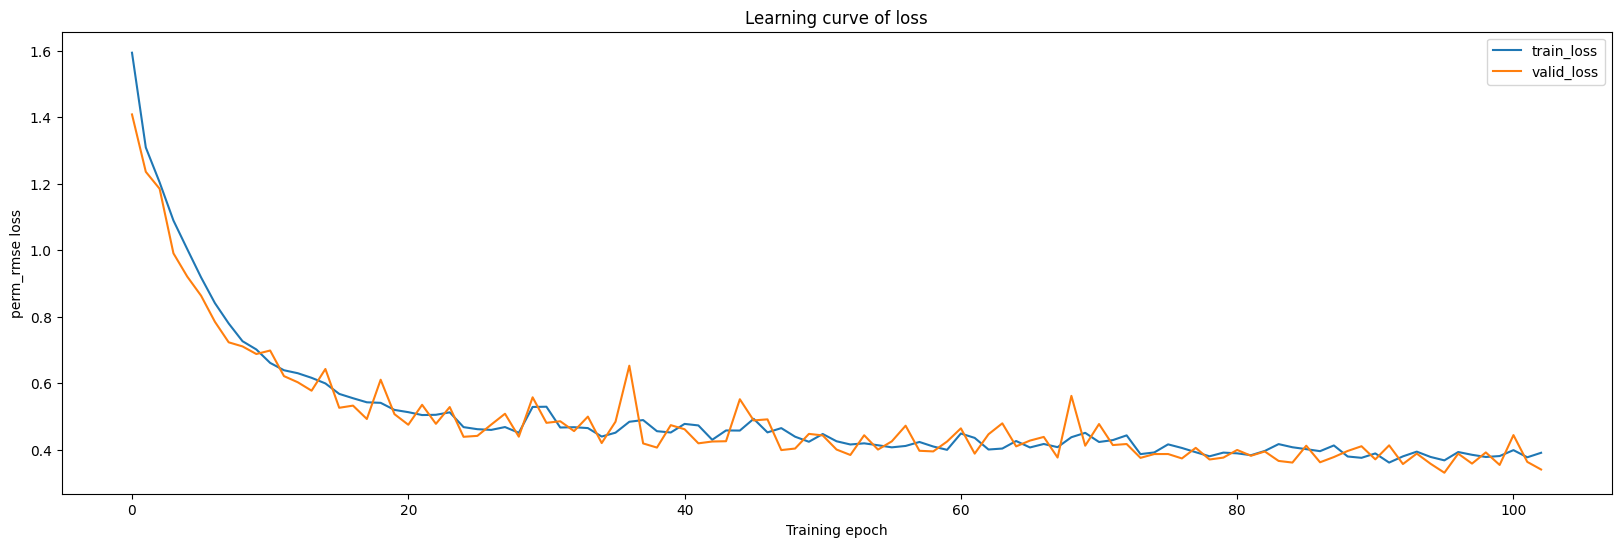

In [10]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(20, 6))#第一个参数是宽
plt.plot(train_loss_record, label='train_loss')
plt.plot(valid_loss_record, label='valid_loss')
# plt.ylim(0., 0.5)
plt.xlabel('Training epoch')
plt.ylabel('perm_rmse loss')
plt.title('Learning curve of {}'.format("loss"))
plt.legend()
# plt.show()



plt.legend()
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-7-dce6489c3731>:67: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  allPerms=torch.zeros(size,np.math.factorial(num_sources)*num_sources,requires_grad=True);


recode_lossT1 [0.15622107942516988, 0.2068901063922124, 0.2186806328021563, 0.21628897809065306, 0.2185666173314437]
record_accT1 [37.249599358974365, 37.389823717948715, 35.12620192307692, 35.95753205128205, 35.71714743589743]


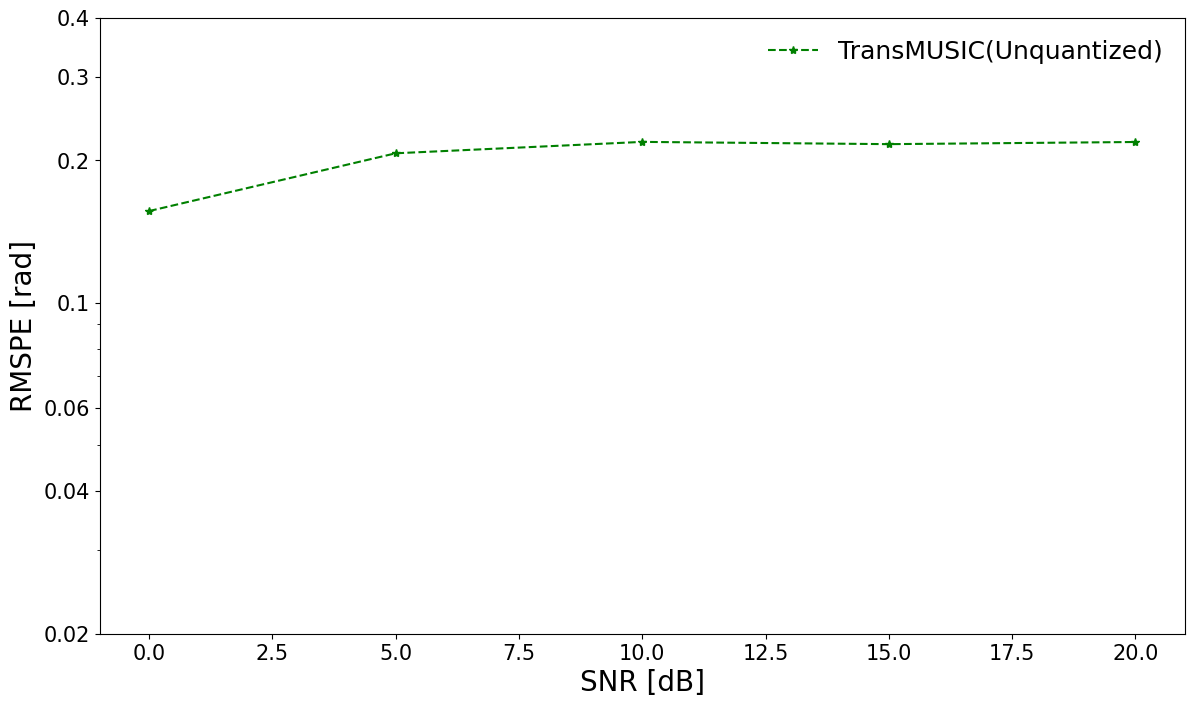

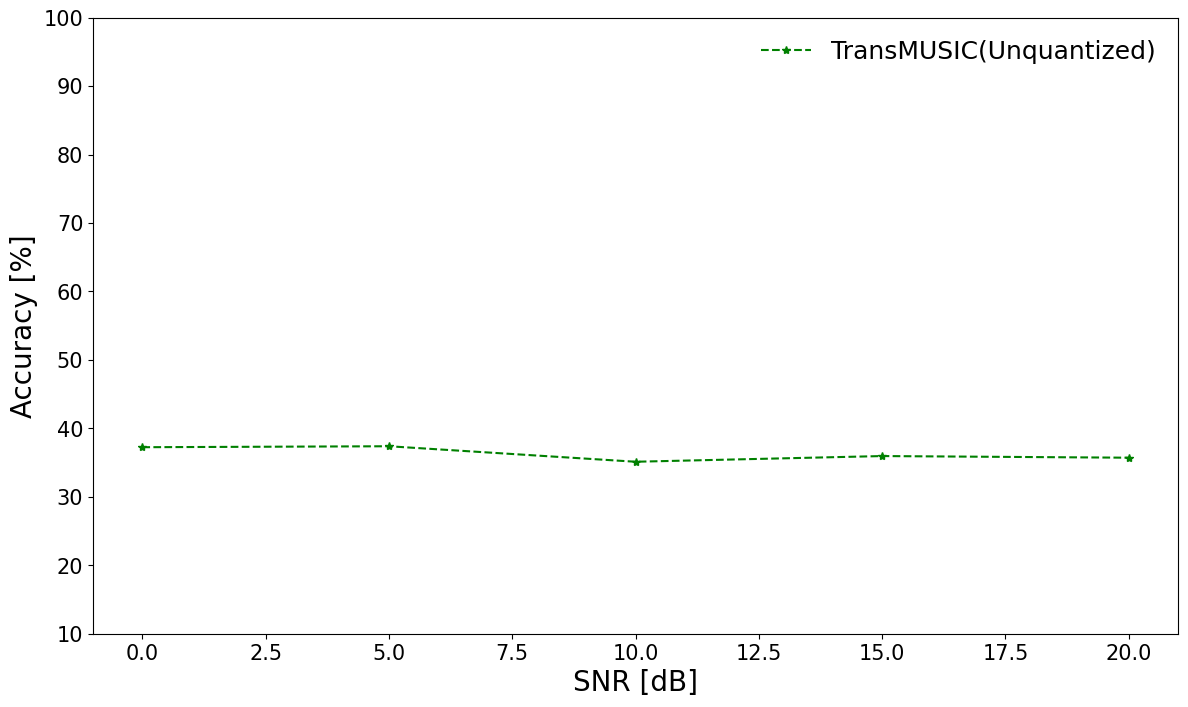

In [11]:
net.load_state_dict(torch.load(model_location))#将上面保存的模型参数加载


record_accT1=[]
recode_lossT1=[]
test_list=[]
snr_list=[0,5,10,15,20]


for i in tqdm(range(len(snr_list))):

    num_s=10000
    x_test,y_test=create_complete_test_dataset(num_s,snr=snr_list[i], snapshots=200,num_sources=[2,3,4,5], coherent=False)
    x_test=np.concatenate([x_test.real, x_test.imag], axis=1)#复数拼接成实数

    x_test1=np.sign(x_test)#单比特量化

    test_set = Deep_augmented_MUSIC_Dataset(x_test,y_test)
    test_loader = DataLoader(test_set, batch_size=128, shuffle=False,drop_last=True)  # 自动分配batch,用于for循环中的迭代，shuffle=True,训练中打乱每次的batch

    test_set_onebit = Deep_augmented_MUSIC_Dataset(x_test1,y_test)
    test_loader_onebit = DataLoader(test_set_onebit, batch_size=128, shuffle=False,drop_last=True)  # 自动分配batch,用于for循环中的迭代，shuffle=True,训练中打乱每次的batch

    test_loss=[]

    test_accs=[]
    net.eval()  # set model to evalutation mode
    for x, y in (test_loader):  # iterate through the dataloader
            with torch.no_grad():  # disable gradient calculation
                x=x.to(device)
                y=y.to(device)

                #计算分类准确率
                x8,x9,_= net(x)  # 前向传播，并将X移入cuda

                prob = F.softmax(x9,dim=1) # dim = 0,在列上进行Softmax;dim=1,在行上进行Softmax

                num_true_t = torch.argmax(y, dim=1)#真实的索引
                num_true_p=torch.argmax(prob,dim=1)
                num_true_p=num_true_p+2#预测的索引
                acc = (num_true_p == num_true_t).float().mean().item()

                test_accs.append(acc)

                loss_=loss_doa_test(x8,y,num_true_t,num_true_p)

                test_loss.append(loss_.item())


    test_losses=sum(test_loss)/len(test_loader)
    test_acc = sum(test_accs) / len(test_accs)#正确率


    record_accT1.append(test_acc*100)
    recode_lossT1.append(test_losses)



print("recode_lossT1",recode_lossT1)
print("record_accT1",record_accT1)





font1 = { 'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 18,
}

font2 = { 'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 20,
}


plt.figure(figsize=(14, 8))#第一个参数是宽
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.plot(snr_list,(recode_lossT1),"g*--",label='TransMUSIC(Unquantized)')


plt.yscale("log")
yticks = [0.02,0.04,0.06,0.1,0.2,0.3,0.4]
plt.yticks(ticks=yticks,labels=['0.02','0.04','0.06','0.1','0.2','0.3','0.4'],fontsize=15)
plt.xlabel('SNR [dB]',font2)
plt.ylabel('RMSPE [rad]',font2)
# plt.title('test curve of {}'.format("loss"))

plt.legend(prop=font1,frameon=False)
# plt.savefig('SNR_loss.pdf')
plt.show()



plt.figure(figsize=(14, 8))#第一个参数是宽
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(snr_list,record_accT1,"g*--",label='TransMUSIC(Unquantized)')
plt.xlabel('SNR [dB]',font2)
plt.ylabel('Accuracy [%]',font2)
# plt.title('test curve of {}'.format("loss"))

plt.legend(prop=font1,frameon=False)
plt.ylim(10,100)
# plt.savefig('SNR_acc.pdf')
plt.show()


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-7-dce6489c3731>:67: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  allPerms=torch.zeros(size,np.math.factorial(num_sources)*num_sources,requires_grad=True);


recode_lossT1 [0.20503861490541544, 0.19723777258052275, 0.2058187357078378, 0.2165740255314188, 0.2159901928777496]
record_accT1 [41.3661858974359, 41.686698717948715, 38.201121794871796, 36.7588141025641, 36.15785256410257]


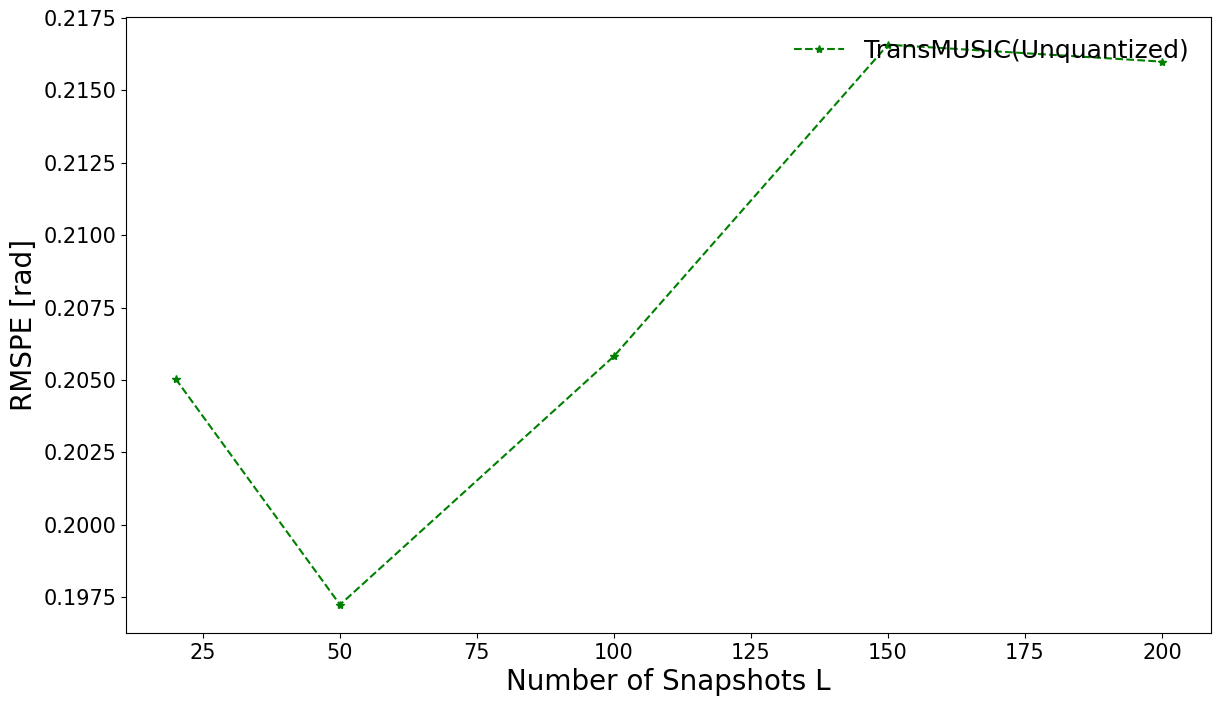

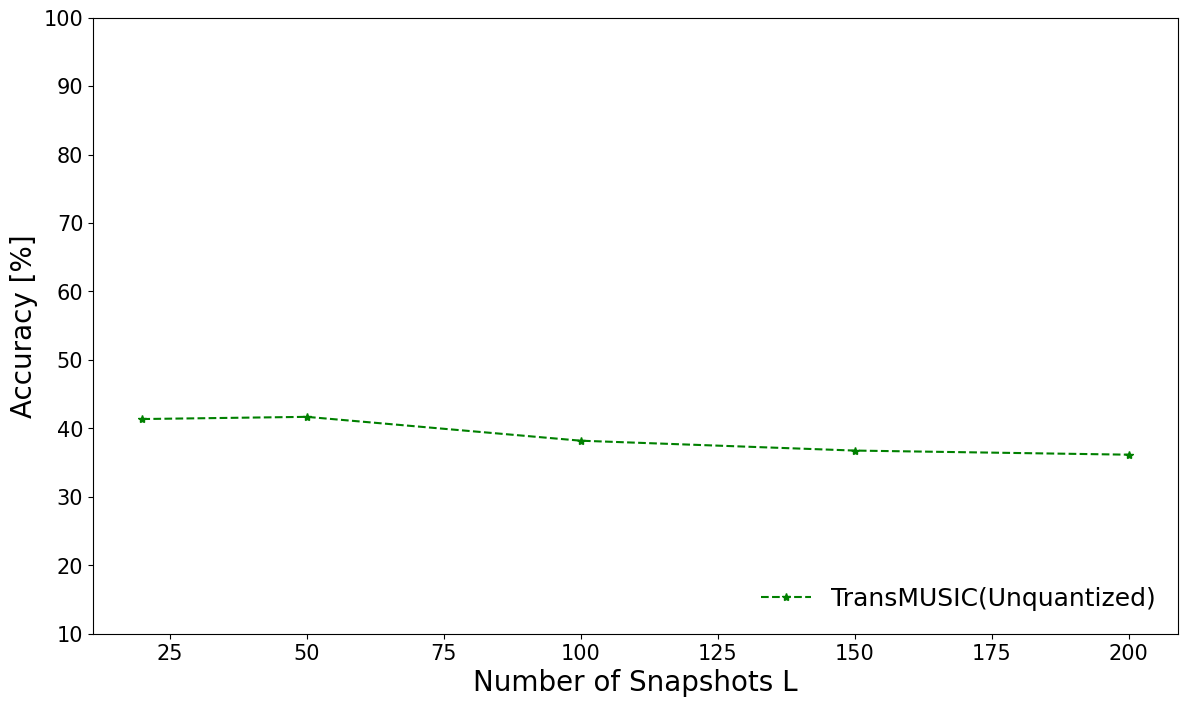

In [12]:
net.load_state_dict(torch.load(model_location))#将上面保存的模型参数加载


test_list=[]
snapshots_list=[20,50,100,150,200]

record_accT1=[]
recode_lossT1=[]


for i in tqdm(range(len(snapshots_list))):

    num_s=5000

    x_test,y_test=create_complete_test_dataset(num_s,10,snapshots_list[i],[2,3,4,5],coherent=False)
    x_test=np.concatenate([x_test.real, x_test.imag], axis=1)#复数拼接成实数
    x_test1=np.sign(x_test)#单比特量化


    test_set = Deep_augmented_MUSIC_Dataset(x_test,y_test)
    test_loader = DataLoader(test_set, batch_size=16, shuffle=False,drop_last=True)  # 自动分配batch,用于for循环中的迭代，shuffle=True,训练中打乱每次的batch

    test_set_onebit = Deep_augmented_MUSIC_Dataset(x_test1,y_test)
    test_loader_onebit = DataLoader(test_set_onebit, batch_size=16, shuffle=False,drop_last=True)  # 自动分配batch,用于for循环中的迭代，shuffle=True,训练中打乱每次的batch

    test_loss=[]

    test_accs=[]
    net.eval()  # set model to evalutation mode
    for x, y in (test_loader):  # iterate through the dataloader
            with torch.no_grad():  # disable gradient calculation
                x=x.to(device)
                y=y.to(device)

                #计算分类准确率
                x8,x9,_= net(x)  # 前向传播，并将X移入cuda


                prob = F.softmax(x9,dim=1) # dim = 0,在列上进行Softmax;dim=1,在行上进行Softmax

                num_true_t = torch.argmax(y, dim=1)#真实的索引
                num_true_p=torch.argmax(prob,dim=1)
                num_true_p=num_true_p+2#预测的索引
                acc = (num_true_p == num_true_t).float().mean().item()

                test_accs.append(acc)

                loss_=loss_doa_test(x8,y,num_true_t,num_true_p)

                test_loss.append(loss_.item())


    test_losses=sum(test_loss)/len(test_loader)
    test_acc = sum(test_accs) / len(test_accs)#正确率


    record_accT1.append(test_acc*100)
    recode_lossT1.append(test_losses)


print("recode_lossT1",recode_lossT1)
print("record_accT1",record_accT1)








snapshots_list=[20,50,100,150,200]


font1 = { 'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 18,
}

font2 = { 'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 20,
}

plt.figure(figsize=(14, 8))#第一个参数是宽
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(snapshots_list,(recode_lossT1),"g*--",label='TransMUSIC(Unquantized)')


plt.xlabel('Number of Snapshots L',font2)
plt.ylabel('RMSPE [rad]',font2)
# plt.title('test curve of {}'.format("loss"))

plt.legend(prop=font1,frameon=False,loc='upper right')
# plt.savefig('nocoherent_snap_loss.pdf')
plt.show()

plt.figure(figsize=(14, 8))#第一个参数是宽
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(snapshots_list,record_accT1,"g*--",label='TransMUSIC(Unquantized)')


plt.xlabel('Number of Snapshots L',font2)
plt.ylabel('Accuracy [%]',font2)
# plt.title('test curve of {}'.format("loss"))

plt.legend(prop=font1,frameon=False,loc='lower right')

plt.ylim(10,100)
# plt.savefig('nocoherent_snap_acc.pdf')
plt.show()

In [13]:
# transmusic
net.load_state_dict(torch.load(model_location))#将上面保存的模型参数加载

test_list=[]
d_list=[2,3,4,5]

record_accT1=[]
recode_lossT1=[]


for i in tqdm(range(len(d_list))):

    num_s=2000
    x_test,y_test=create_complete_test_dataset(num_s,snr=10, snapshots=200,num_sources=[d_list[i]], coherent=False)
    x_test=np.concatenate([x_test.real, x_test.imag], axis=1)#复数拼接成实数
    x_test1=np.sign(x_test)#单比特量化


    test_set = Deep_augmented_MUSIC_Dataset(x_test,y_test)
    test_loader = DataLoader(test_set, batch_size=128, shuffle=False,drop_last=True)  # 自动分配batch,用于for循环中的迭代，shuffle=True,训练中打乱每次的batch

    test_set_onebit = Deep_augmented_MUSIC_Dataset(x_test1,y_test)
    test_loader_onebit = DataLoader(test_set_onebit, batch_size=128, shuffle=False,drop_last=True)  # 自动分配batch,用于for循环中的迭代，shuffle=True,训练中打乱每次的batch

    test_loss=[]

    test_accs=[]
    net.eval()  # set model to evalutation mode
    for x, y in (test_loader):  # iterate through the dataloader
            with torch.no_grad():  # disable gradient calculation
                x=x.to(device)
                y=y.to(device)

                #计算分类准确率
                x8,x9,_= net(x)  # 前向传播，并将X移入cuda


                prob = F.softmax(x9,dim=1) # dim = 0,在列上进行Softmax;dim=1,在行上进行Softmax

                num_true_t = torch.argmax(y, dim=1)#真实的索引
                num_true_p=torch.argmax(prob,dim=1)
                num_true_p=num_true_p+2#预测的索引
                acc = (num_true_p == num_true_t).float().mean().item()

                test_accs.append(acc)

                loss_=loss_doa_test(x8,y,num_true_t,num_true_p)

                test_loss.append(loss_.item())


    test_losses=sum(test_loss)/len(test_loader)
    test_acc = sum(test_accs) / len(test_accs)#正确率


    record_accT1.append(test_acc*100)
    recode_lossT1.append(test_losses)


print("recode_lossT1",recode_lossT1)
print("record_accT1",record_accT1)

  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-7-dce6489c3731>:67: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  allPerms=torch.zeros(size,np.math.factorial(num_sources)*num_sources,requires_grad=True);


recode_lossT1 [0.25307199358940125, 0.18300179640452066, 0.20962884227434794, 0.20689914226531983]
record_accT1 [19.479166666666668, 16.822916666666668, 24.635416666666668, 83.85416666666666]
